In [1]:
# Imports
import os
import sys
import torch
import numpy as np
from tqdm import tqdm
import SimpleITK as sitk
from matplotlib import pyplot as plt

# Add the setup_data_vars function as we will need it to find the directory for the training data.
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars
setup_data_vars()

dir2 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '0_utils'))
if not dir2 in sys.path: sys.path.append(dir2)

from dataload_handler import DataLoaderHandler
from checkpoint_handler import CheckpointHandler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
import argparse

parser = argparse.ArgumentParser()

# Inspired by orginal code from the MedSAM/extensions/point_prompt

# 1. Add the anatomy on which we will fine-tune
parser.add_argument(
    '--anatomy',
    type=str,
    help='Anatomy on which to fine-tune the model. Note: this is case sensitive, please capitalize the first letter and accronyms such as CTVn or CTVp.',
    required=True
)

_StoreAction(option_strings=['--anatomy'], dest='anatomy', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, required=True, help='Anatomy on which to fine-tune the model. Note: this is case sensitive, please capitalize the first letter and accronyms such as CTVn or CTVp.', metavar=None)

In [3]:
args = parser.parse_args(
    ['--anatomy', 'CTVn']
)

anatomy = args.anatomy

## Setup classes for loading up the stuff

In [4]:
lowres = True
save_dir = os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres_2', anatomy)
checkpoint_path = os.path.join(os.environ['PROJECT_DIR'], 'models', 'MedSAM', 'work_dir', 'MedSAM', 'medsam_vit_b.pth')
model_path = os.path.join(save_dir, 'checkpoint_best.pth')
data_split = os.path.join(save_dir, 'data_splits.json')
img_dir = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'imgs')
gt_dir = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'gts', anatomy)
batch_size = 1
num_workers = 16

use_boxes = True
use_positive_points = False

assert os.path.exists(model_path), f"Model path {model_path} does not exist."
assert os.path.exists(data_split), f"Data split {data_split} does not exist."
assert os.path.exists(img_dir), f"Raw data {img_dir} does not exist."
assert os.path.exists(gt_dir), f"Ground truth data {gt_dir} does not exist."

In [5]:
dlh = DataLoaderHandler(save_dir = save_dir,
                        image_dir = img_dir,
                        gt_dir = gt_dir,
                        batch_size = batch_size,
                        num_workers = num_workers,
                        data_aug = False,
                        max_points = 0,
                        box_padding = 5,
                        max_box_points = 5)
dlh.load_split_from_json()
dlh.setup_specific_dataloader('validation')
dlh.validation_image_ids

Dataset size (6.6 GiB) fits in cache limit (20 GiB). Allocating space to cache all 6718 samples.


{2, 10, 11, 16, 38, 42, 43, 46, 49, 51, 56, 57, 66, 71, 73, 74, 77, 79, 92, 93}

In [6]:
cph = CheckpointHandler(save_dir, checkpoint_path, device)
if cph.checkpoint_exists():
    model, optimizer, epoch, best_loss = cph.load_checkpoint()
    print(f'Loaded the model for anatomy {anatomy} from epoch {epoch}')

Loaded the model for anatomy CTVn from epoch 74


## Main validaiton loop

In [7]:
import pandas as pd

# create a pandas dataframe to store the name, axis, dice, jaccard, volume_similarity, apl, surface_distance, and hausdorff_distance

df = pd.DataFrame(columns=['name', 'axis', 'dice', 'jaccard', 'volume_similarity', 'apl', 'surface_distance', 'hausdorff_distance'])

# load in the processed data if it already exists
# if os.path.exists(os.path.join(save_dir, 'validation.csv')):
#     df = pd.read_csv(os.path.join(save_dir, 'validation.csv'))

In [8]:
df

,name,axis,dice,jaccard,volume_similarity,apl,surface_distance,hausdorff_distance


In [24]:
import SimpleITK as sitk
import os

def upsample_sitk_image_to_original(y_gt_sitk, y_pred_sitk, image_name, axis_num):
    # Get image id from image_name
    image_id = int(image_name.split('_')[2].split('-')[0])
    original_file_path = os.path.join(
        os.environ.get('nnUNet_raw'),
        os.environ.get('Anorectum'),
        os.environ.get('data_trainingImages'),
        # f'zzAMLART_{image_id:03d}.nii.gz'
        f'zzAMLART_{image_id:03d}_0000.nii.gz'
    )
    # slice_num = int(image_name.split('_')[2].split('-')[1][:-4])

    # Read the original image
    reader = sitk.ImageFileReader()
    reader.SetFileName(original_file_path)
    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    original_spacing = list(reader.GetSpacing())
    original_size = list(reader.GetSize())
    
    # reshape so that the original axis order is preserved

    # (X, X, 1)

    if axis_num == 0:
        y_gt_sitk = sitk.PermuteAxes(y_gt_sitk, [2, 0, 1])
        y_pred_sitk = sitk.PermuteAxes(y_pred_sitk, [2, 0, 1])
    elif axis_num == 1:
        y_gt_sitk = sitk.PermuteAxes(y_gt_sitk, [0, 2, 1])
        y_pred_sitk = sitk.PermuteAxes(y_pred_sitk, [0, 2, 1])

    original_size[axis_num] = 1
    # original_spacing[axis_num] = 1

    y_gt_sitk_new = sitk.Resample(y_gt_sitk, original_size, sitk.Transform(), sitk.sitkNearestNeighbor, y_gt_sitk.GetOrigin(), original_spacing, y_gt_sitk.GetDirection(), 0.0, y_gt_sitk.GetPixelID())
    y_pred_sitk_new = sitk.Resample(y_pred_sitk, original_size, sitk.Transform(), sitk.sitkNearestNeighbor, y_pred_sitk.GetOrigin(), original_spacing, y_pred_sitk.GetDirection(), 0.0, y_pred_sitk.GetPixelID())

    if axis_num == 0:
        y_gt_sitk_new = sitk.PermuteAxes(y_gt_sitk_new, [1, 2, 0])
        y_pred_sitk_new = sitk.PermuteAxes(y_pred_sitk_new, [1, 2, 0])
    elif axis_num == 1:
        y_gt_sitk_new = sitk.PermuteAxes(y_gt_sitk_new, [0, 2, 1])
        y_pred_sitk_new = sitk.PermuteAxes(y_pred_sitk_new, [0, 2, 1])

    return y_gt_sitk_new, y_pred_sitk_new
    
# gt_up, pred_up = upsample_sitk_image_to_original(y_gt_sitk, ypred_sitk, image_name, image_axis)
# print(y_gt_sitk.GetSize(), gt_up.GetSize(), ypred_sitk.GetSize(), pred_up.GetSize())
# print(np.unique(sitk.GetArrayFromImage(gt_up)), np.unique(sitk.GetArrayFromImage(pred_up)))

# # plot the comparison between upsampled and original images

# def plot_comparison(gt, pred, gt_up, pred_up):
#     fig, ax = plt.subplots(2, 2, figsize=(10, 10))
#     ax[0, 0].imshow(sitk.GetArrayFromImage(gt)[0], cmap='gray')
#     ax[0, 0].set_title('Original GT')
#     ax[0, 1].imshow(sitk.GetArrayFromImage(pred)[0], cmap='gray')
#     ax[0, 1].set_title('Original Pred')
#     ax[1, 0].imshow(sitk.GetArrayFromImage(gt_up)[0], cmap='gray')
#     ax[1, 0].set_title('Upsampled GT')
#     ax[1, 1].imshow(sitk.GetArrayFromImage(pred_up)[0], cmap='gray')
#     ax[1, 1].set_title('Upsampled Pred')
#     plt.show()

# plot_comparison(y_gt_sitk, ypred_sitk, gt_up, pred_up)

  0%|          | 0/6718 [00:00<?, ?it/s]

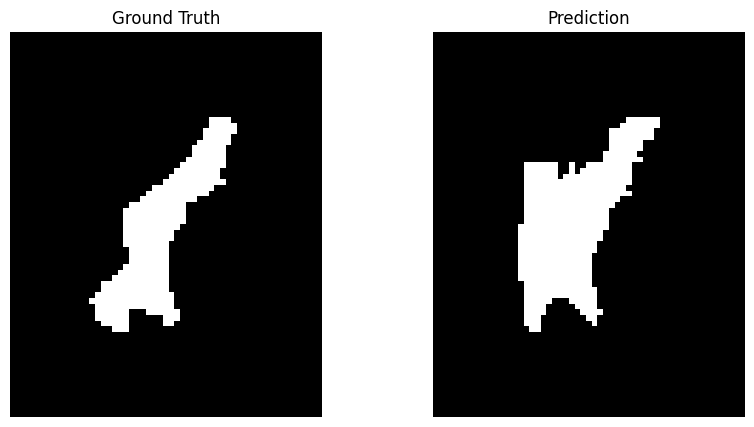

[31]


  0%|          | 1/6718 [00:04<7:37:12,  4.08s/it]

39.35546875
0.32857142857142857


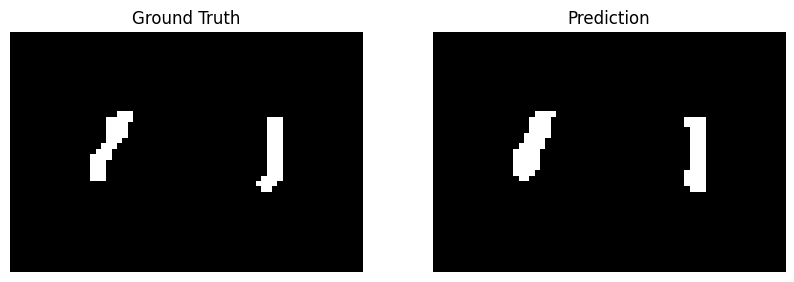

[1]


  0%|          | 2/6718 [00:05<4:53:49,  2.62s/it]

1.634765625
0.7375886524822695


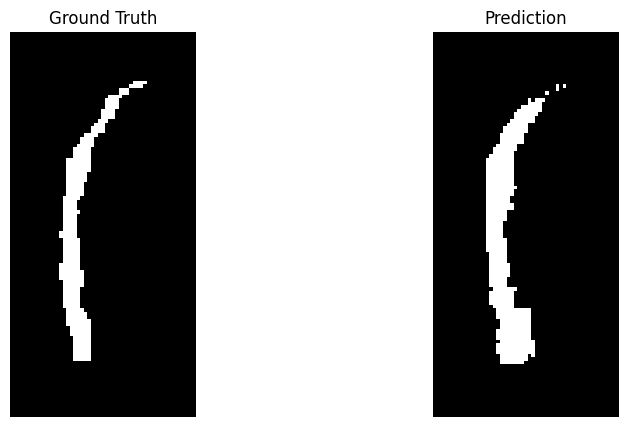

  0%|          | 3/6718 [00:06<3:15:40,  1.75s/it]

[41]
52.05078125
0.26823529411764707


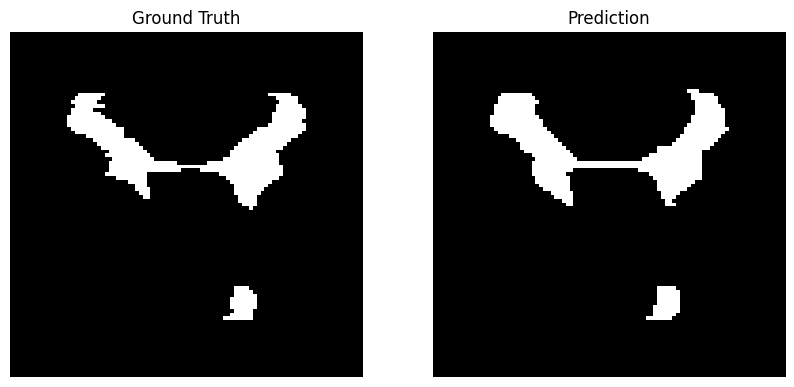

  0%|          | 4/6718 [00:07<2:27:15,  1.32s/it]

[17]
25.30078125
0.607773851590106


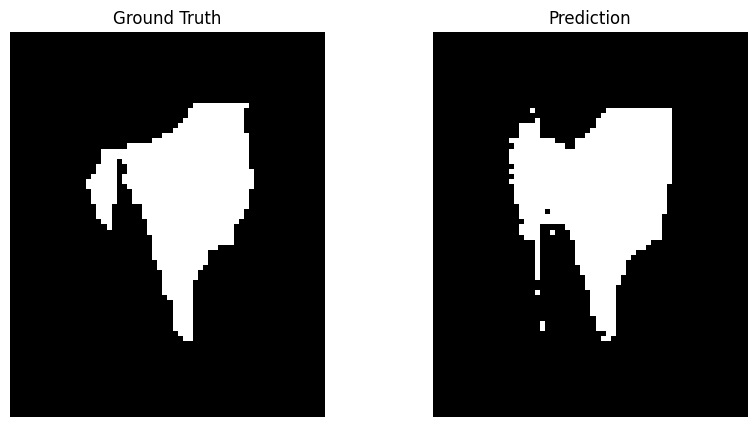

  0%|          | 5/6718 [00:07<1:59:15,  1.07s/it]

[31]
39.35546875
0.4304461942257218


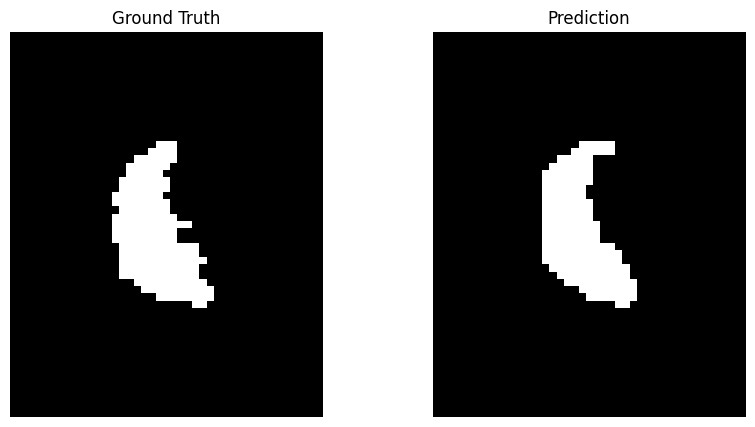

  0%|          | 6/6718 [00:08<1:38:57,  1.13it/s]

[1]
1.738281011581421
0.7006369426751592


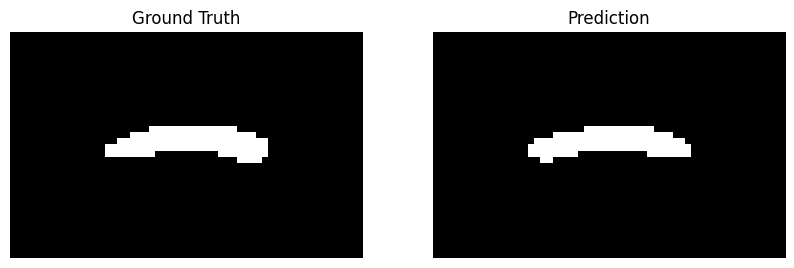

  0%|          | 7/6718 [00:08<1:22:28,  1.36it/s]

[0]
0.0
0.8225806451612904


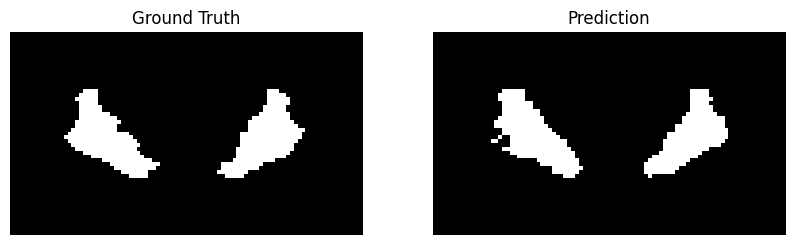

  0%|          | 8/6718 [00:09<1:15:18,  1.48it/s]

[11]
16.37109375
0.42105263157894735


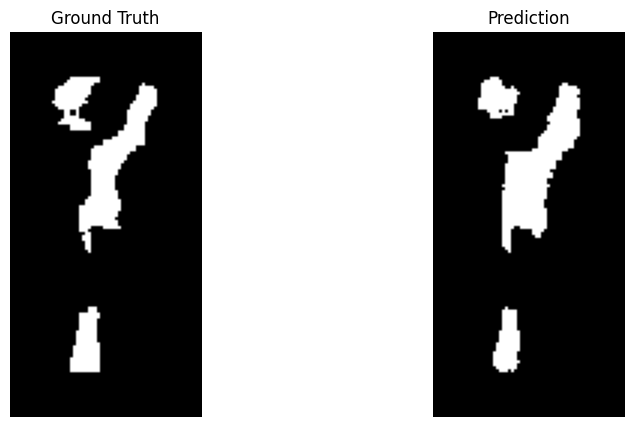

  0%|          | 9/6718 [00:09<1:10:19,  1.59it/s]

[87]
110.44919800758362
0.36451612903225805


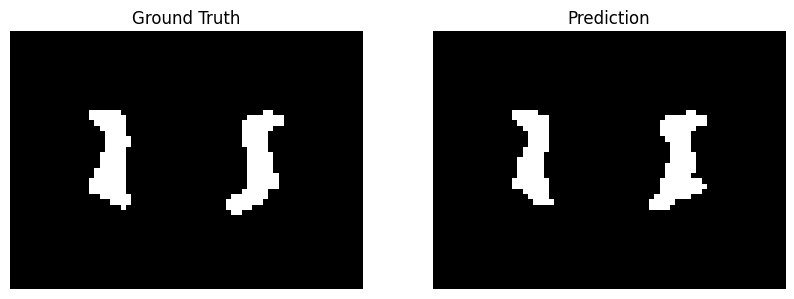

  0%|          | 10/6718 [00:10<1:01:32,  1.82it/s]

[1]
1.8847655057907104
0.7078189300411523


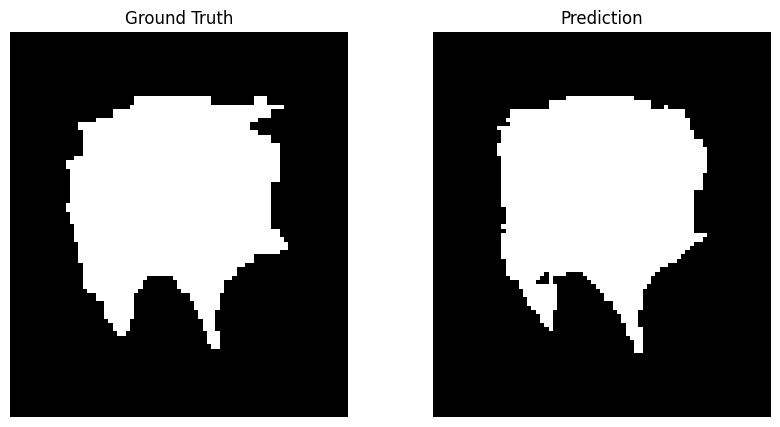

  0%|          | 11/6718 [00:10<53:56,  2.07it/s]  

[50]
48.82810115814209
0.4177449168207024


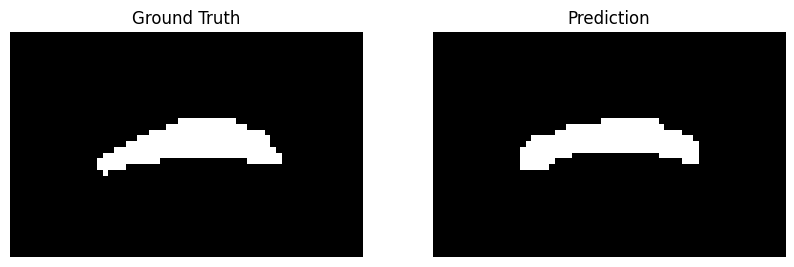

  0%|          | 12/6718 [00:10<47:26,  2.36it/s]

[4]
5.953125
0.45962732919254656


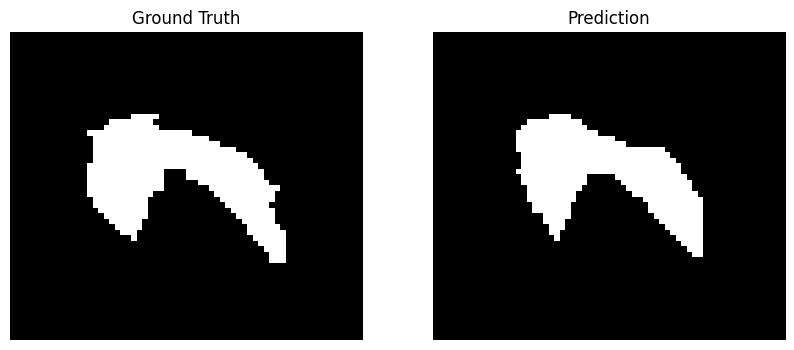

  0%|          | 13/6718 [00:10<43:08,  2.59it/s]

[8]
7.8125
0.541095890410959


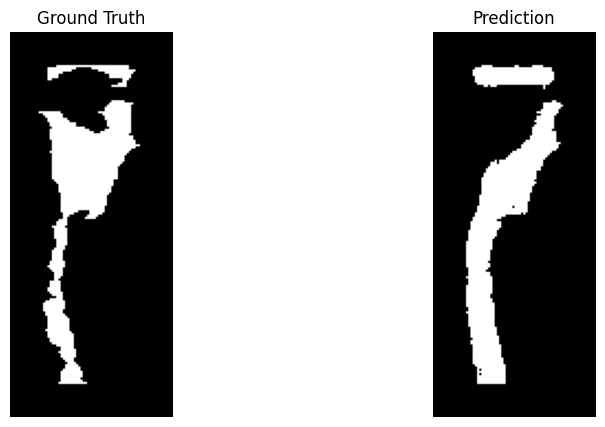

  0%|          | 14/6718 [00:11<44:46,  2.50it/s]

[222]
216.796875
0.24276377217553688


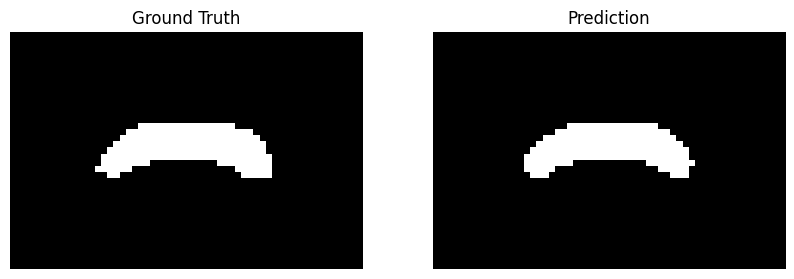

  0%|          | 15/6718 [00:11<42:23,  2.64it/s]

[0]
0.0
0.8552631578947368


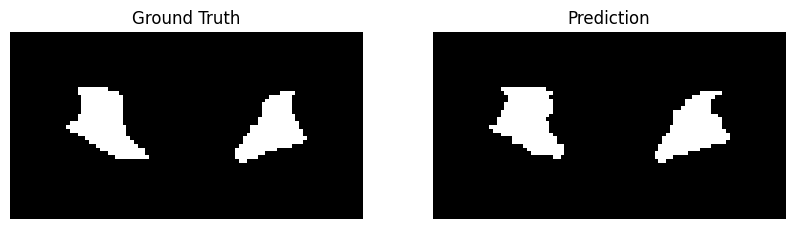

  0%|          | 17/6718 [00:12<32:28,  3.44it/s]

[6]
8.9296875
0.6084142394822006


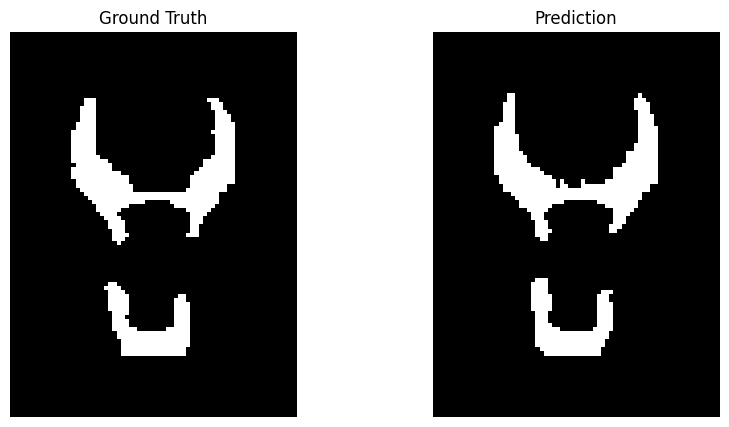

  0%|          | 18/6718 [00:12<35:02,  3.19it/s]

[6]
9.80859375
0.6708860759493671


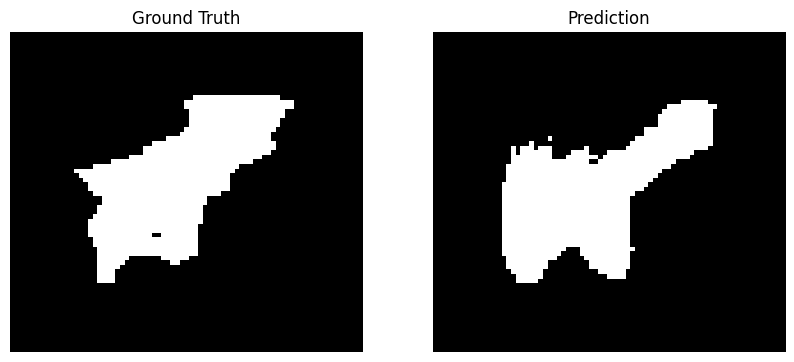

  0%|          | 19/6718 [00:12<34:23,  3.25it/s]

[71]
69.33590364456177
0.21890547263681592


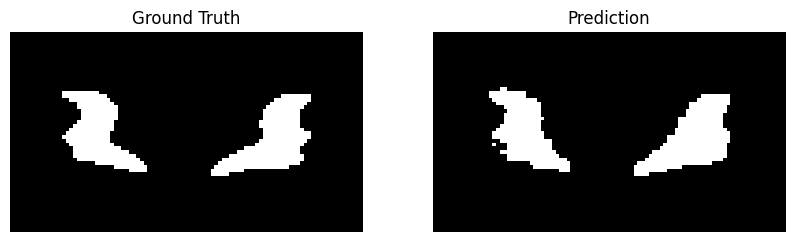

  0%|          | 21/6718 [00:13<30:23,  3.67it/s]

[15]
22.32421875
0.5541561712846348


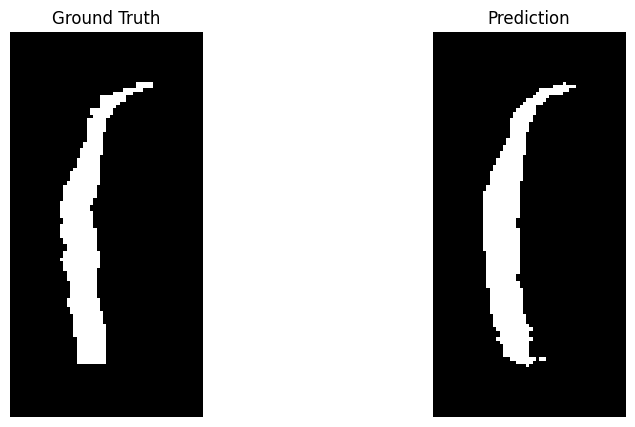

  0%|          | 22/6718 [00:13<31:59,  3.49it/s]

[6]
5.859375
0.6121593291404612


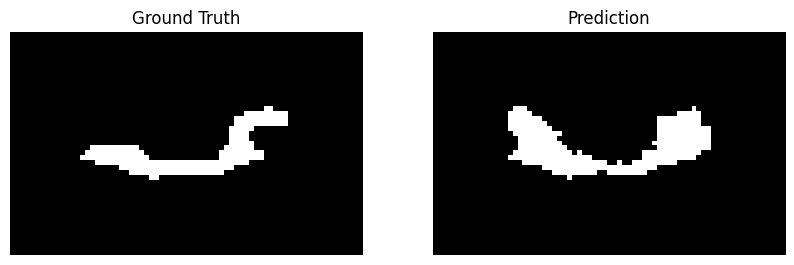

  0%|          | 23/6718 [00:13<33:40,  3.31it/s]

[14]
22.88671875
0.5193798449612403


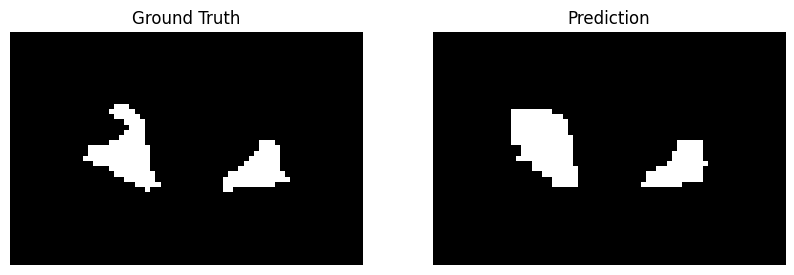

  0%|          | 24/6718 [00:14<36:01,  3.10it/s]

[7]
11.443359375
0.5816326530612245


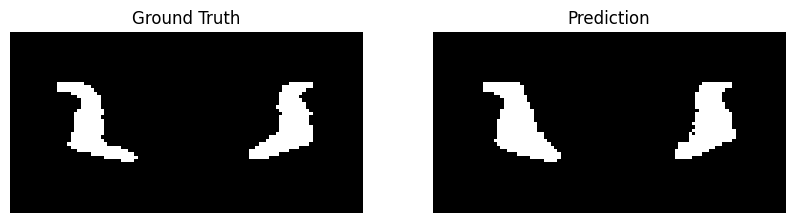

  0%|          | 25/6718 [00:14<37:41,  2.96it/s]

[27]
40.18359375
0.5132275132275133


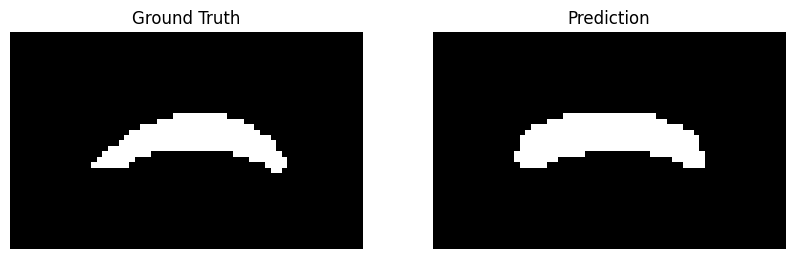

  0%|          | 26/6718 [00:15<37:11,  3.00it/s]

[8]
11.90625
0.6310160427807486


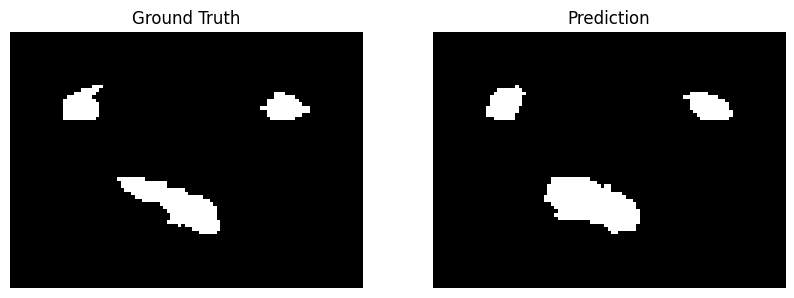

  0%|          | 27/6718 [00:15<42:08,  2.65it/s]

[18]
26.7890625
0.46296296296296297


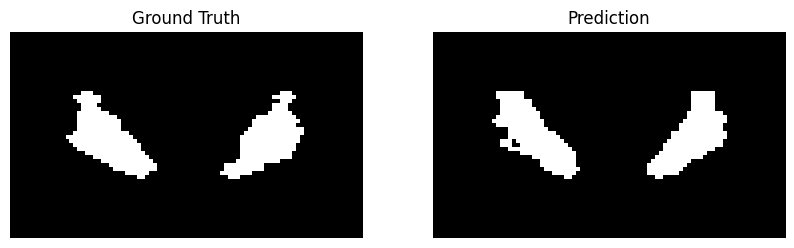

  0%|          | 28/6718 [00:15<41:54,  2.66it/s]

[12]
17.859375
0.4090909090909091


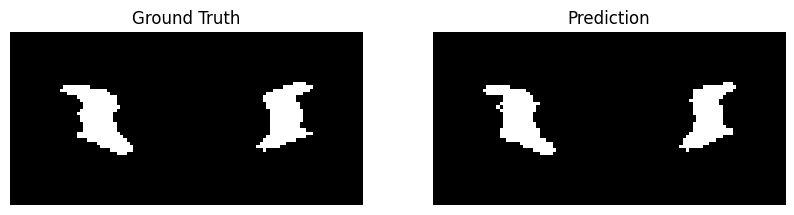

  0%|          | 29/6718 [00:16<41:51,  2.66it/s]

[1]
1.738281011581421
0.6608187134502924


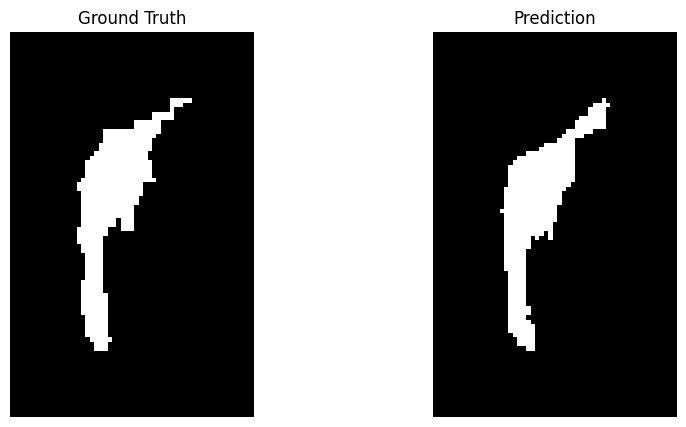

  0%|          | 30/6718 [00:16<39:39,  2.81it/s]

[18]
22.851558208465576
0.5132743362831859


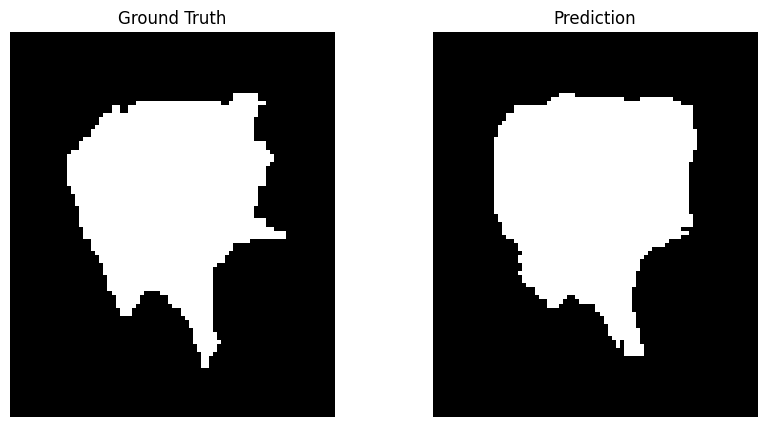

  0%|          | 31/6718 [00:16<37:37,  2.96it/s]

[59]
57.617159366607666
0.31297709923664124


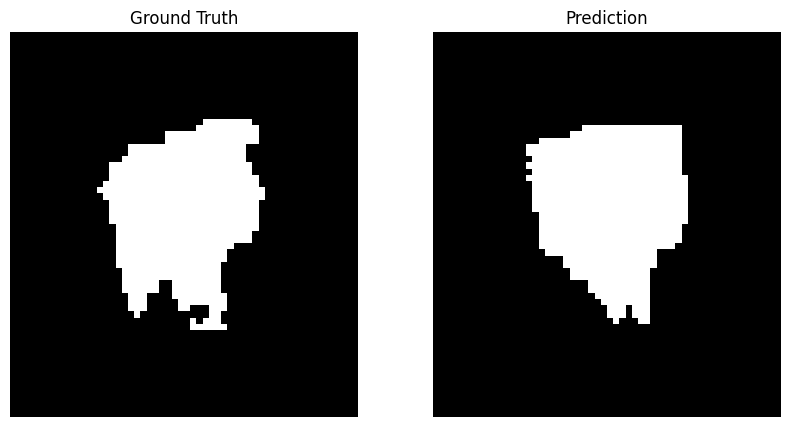

  0%|          | 32/6718 [00:17<36:21,  3.06it/s]

[24]
30.4687442779541
0.3448275862068966


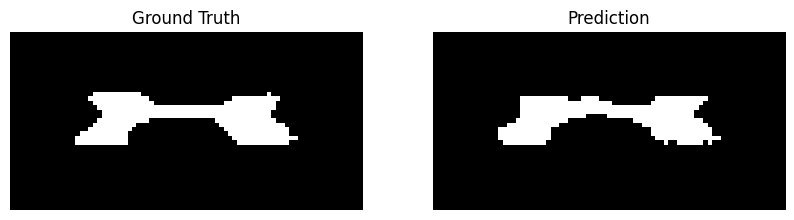

  0%|          | 33/6718 [00:17<34:34,  3.22it/s]

[1]
1.48828125
0.6482758620689655


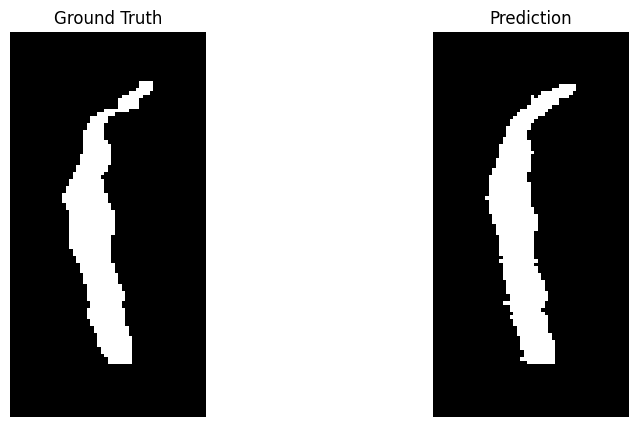

  1%|          | 34/6718 [00:17<35:17,  3.16it/s]

[7]
6.835934162139893
0.5581395348837209


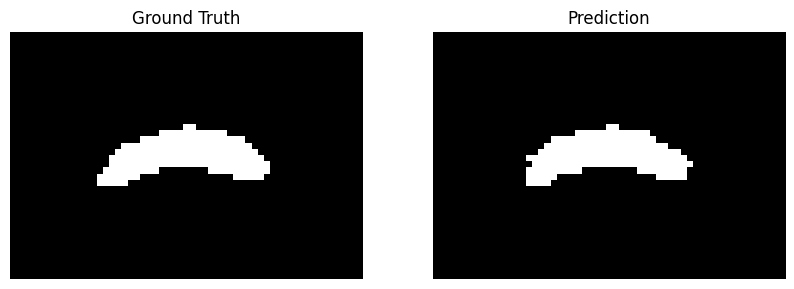

  1%|          | 35/6718 [00:18<35:52,  3.11it/s]

[0]
0.0
0.8666666666666667


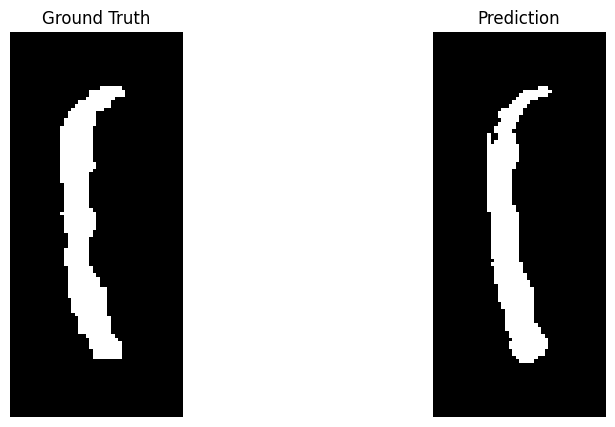

  1%|          | 36/6718 [00:18<47:17,  2.35it/s]

[25]
29.296875
0.35348837209302325


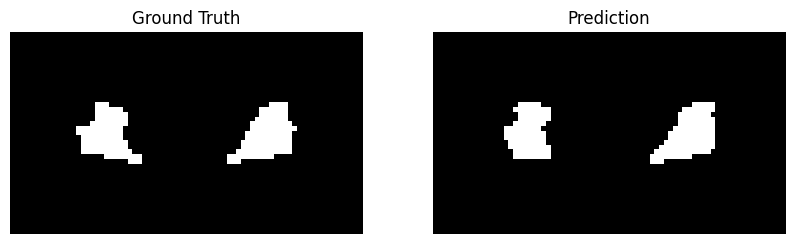

  1%|          | 37/6718 [00:19<45:07,  2.47it/s]

[4]
7.34375
0.7272727272727273


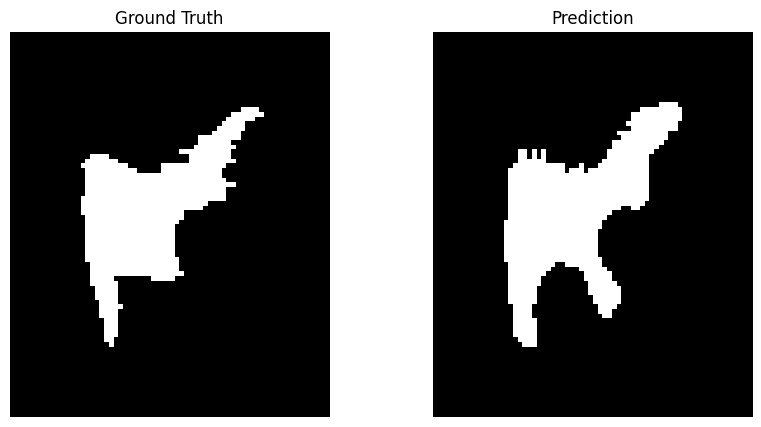

  1%|          | 38/6718 [00:19<42:43,  2.61it/s]

[15]
14.6484375
0.3611111111111111


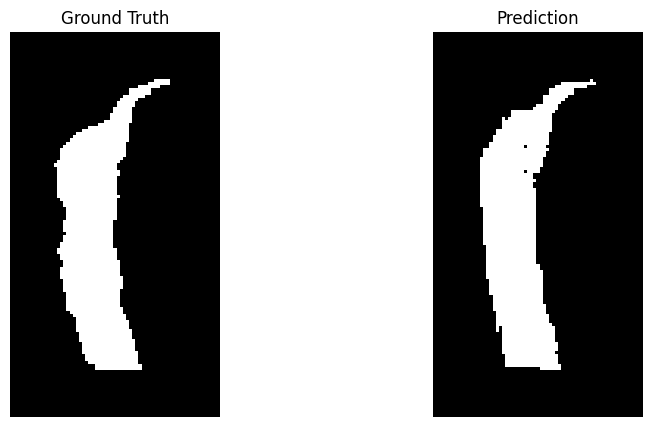

  1%|          | 39/6718 [00:19<40:10,  2.77it/s]

[18]
17.578125
0.4482758620689655


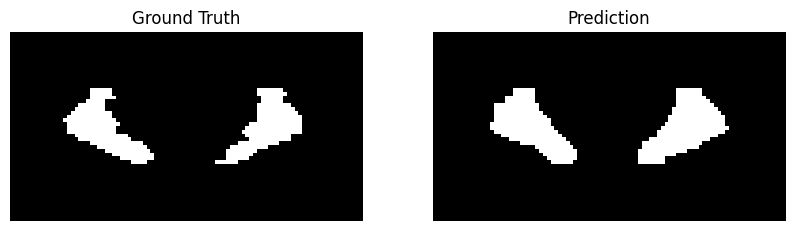

  1%|          | 40/6718 [00:20<39:44,  2.80it/s]

[30]
52.14843034744263
0.44837758112094395


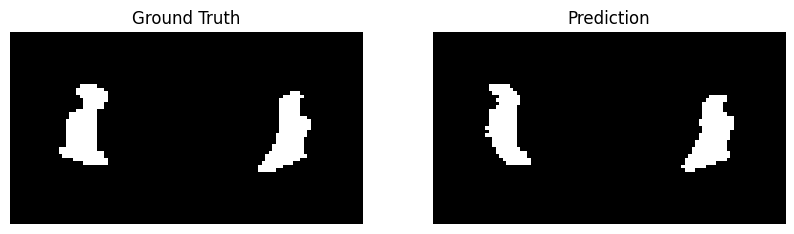

  1%|          | 41/6718 [00:20<40:16,  2.76it/s]

[17]
25.30078125
0.5490196078431373


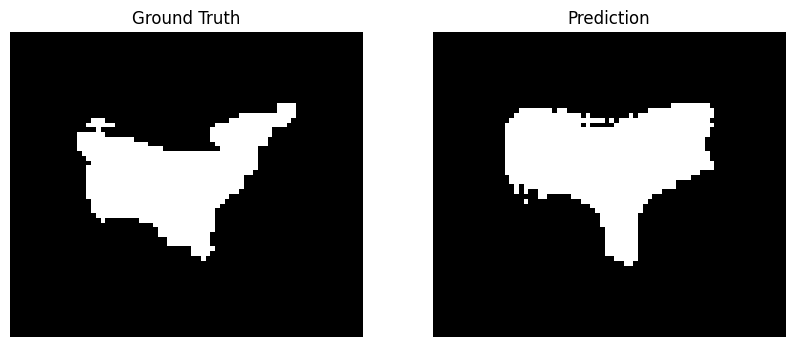

  1%|          | 42/6718 [00:20<38:21,  2.90it/s]

[81]
79.1015625
0.1772853185595568


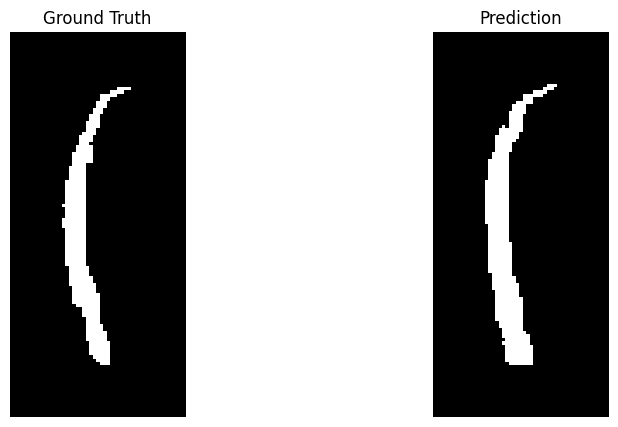

  1%|          | 43/6718 [00:21<36:18,  3.06it/s]

[19]
24.121089220046997
0.568019093078759


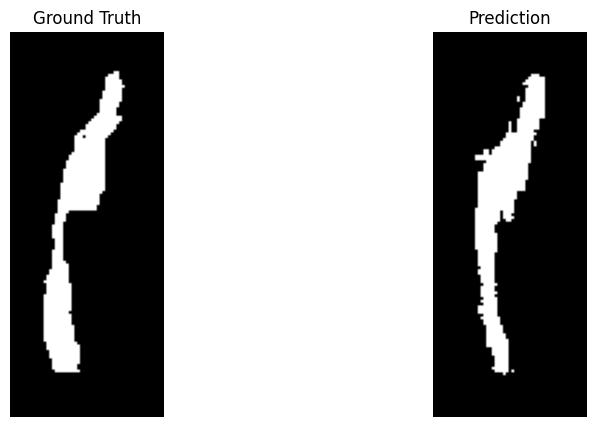

  1%|          | 44/6718 [00:21<35:16,  3.15it/s]

[97]
123.14453125
0.23948220064724918


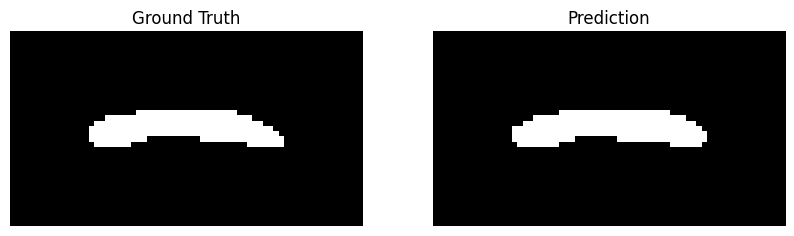

  1%|          | 45/6718 [00:21<35:01,  3.18it/s]

[0]
0.0
0.8522727272727273


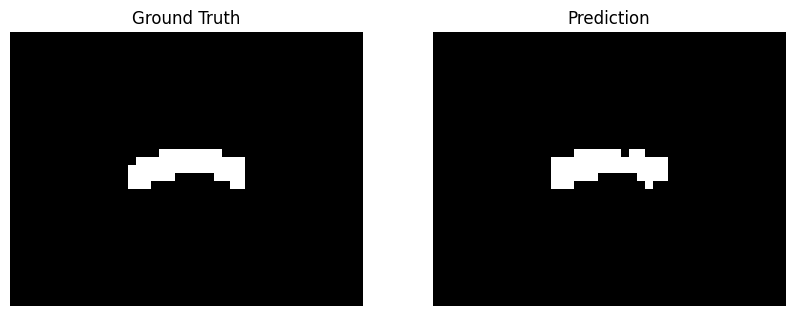

  1%|          | 46/6718 [00:21<33:54,  3.28it/s]

[0]
0.0
0.8641975308641975


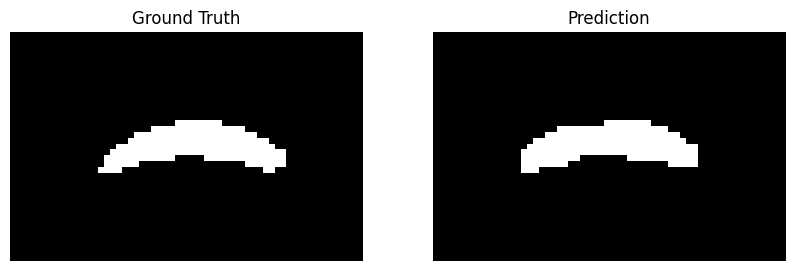

  1%|          | 47/6718 [00:22<33:53,  3.28it/s]

[3]
4.46484375
0.6832298136645962


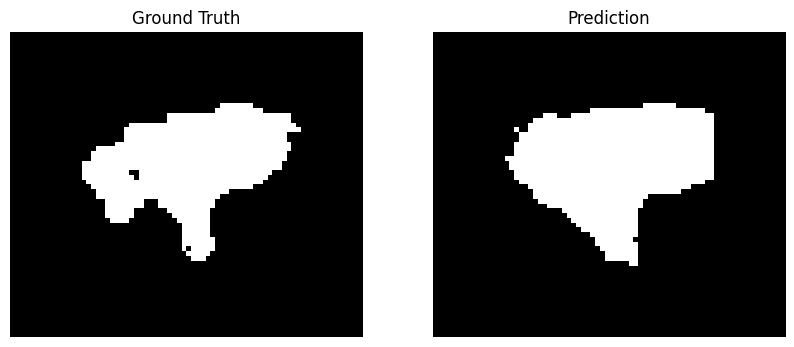

  1%|          | 48/6718 [00:22<34:52,  3.19it/s]

[50]
48.828125
0.2314540059347181


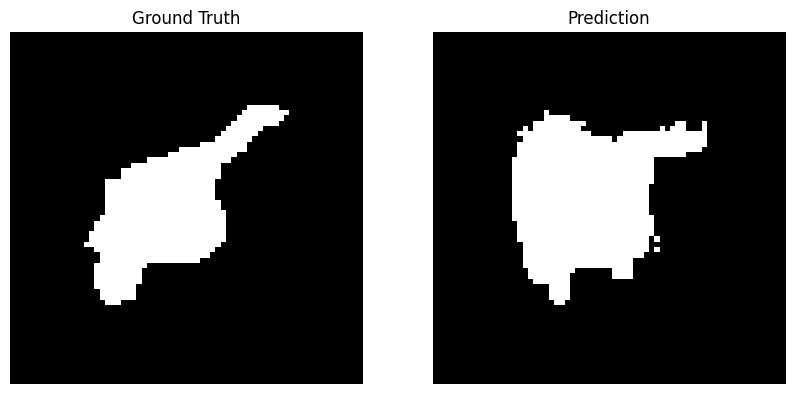

  1%|          | 49/6718 [00:22<34:56,  3.18it/s]

[53]
51.7578125
0.14420062695924765


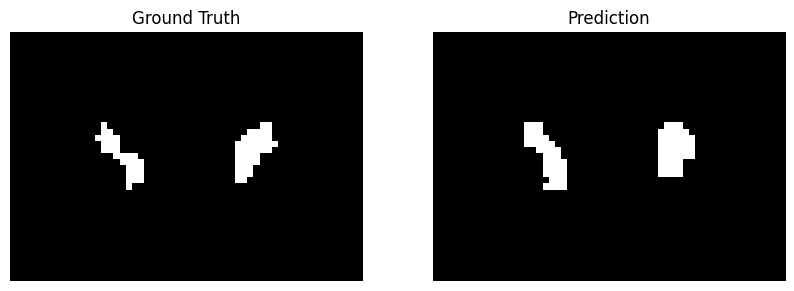

  1%|          | 50/6718 [00:23<36:40,  3.03it/s]

[0]
0.0
0.5689655172413793


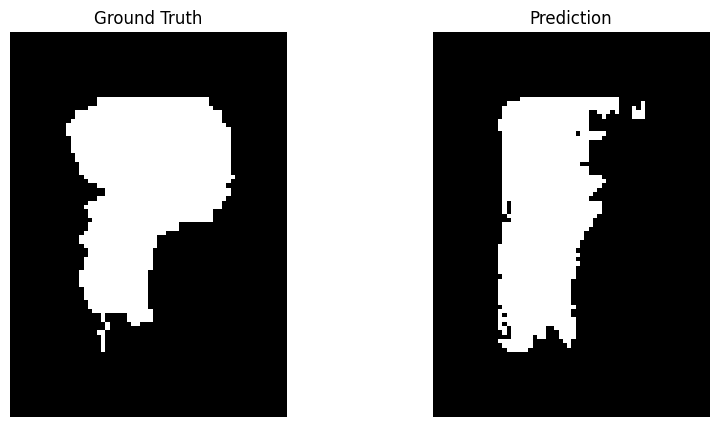

  1%|          | 51/6718 [00:23<37:30,  2.96it/s]

[72]
84.375
0.29914529914529914


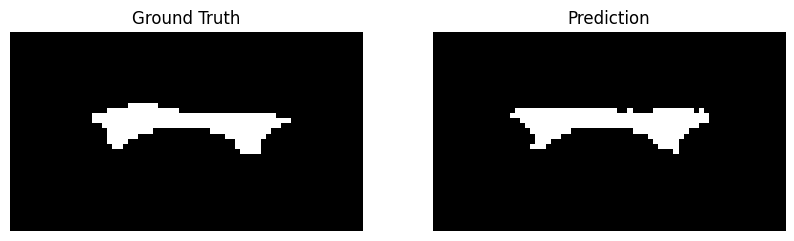

  1%|          | 52/6718 [00:23<35:25,  3.14it/s]

[0]
0.0
0.6798029556650246


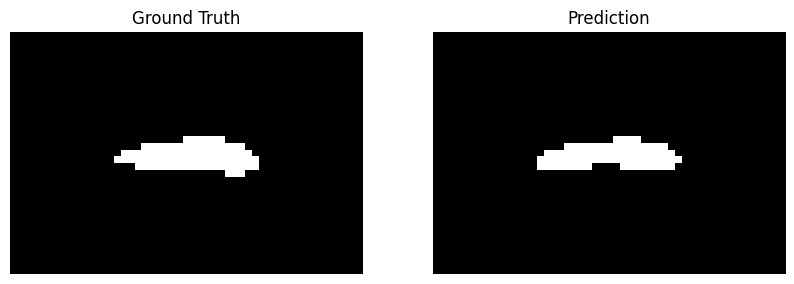

  1%|          | 53/6718 [00:24<34:11,  3.25it/s]

[0]
0.0
0.7551020408163265


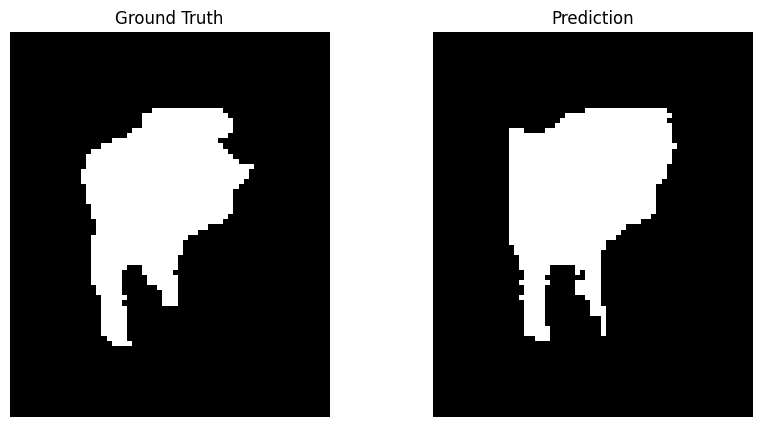

  1%|          | 54/6718 [00:24<35:00,  3.17it/s]

[16]
20.3125
0.5065963060686016


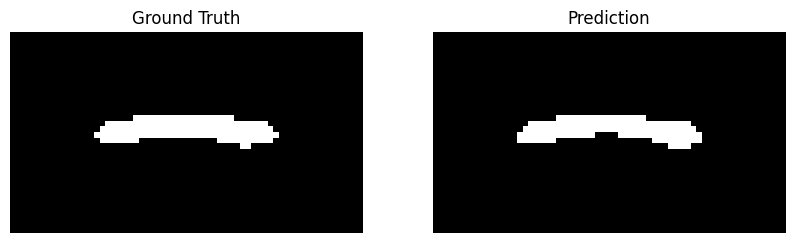

  1%|          | 55/6718 [00:24<34:47,  3.19it/s]

[0]
0.0
0.8157894736842105


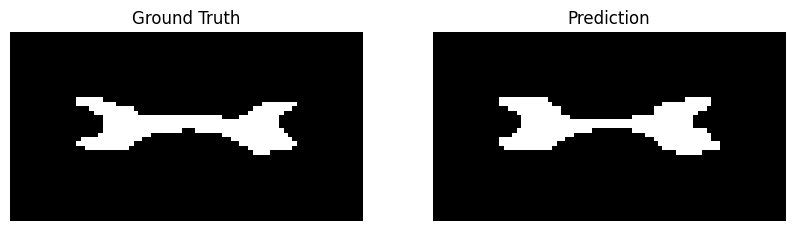

  1%|          | 56/6718 [00:25<34:09,  3.25it/s]

[7]
10.41796875
0.5425867507886435


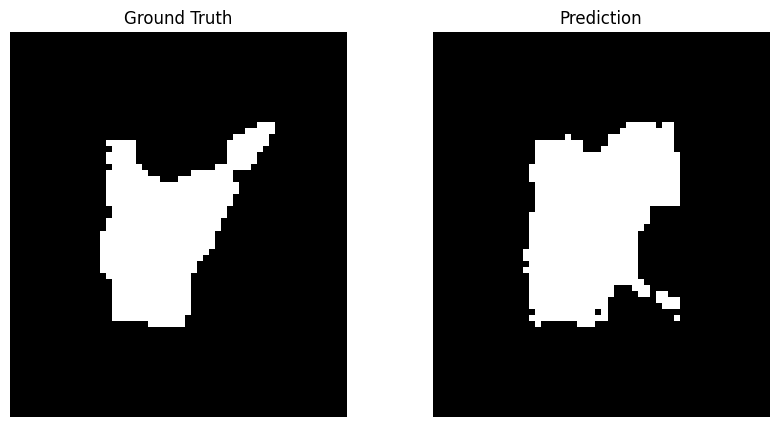

  1%|          | 57/6718 [00:25<35:23,  3.14it/s]

[36]
45.703125
0.35986159169550175


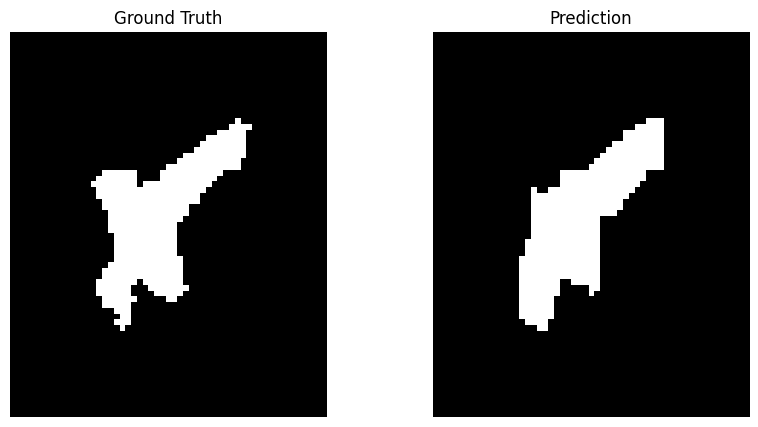

  1%|          | 58/6718 [00:25<37:03,  3.00it/s]

[20]
25.390625
0.41025641025641024


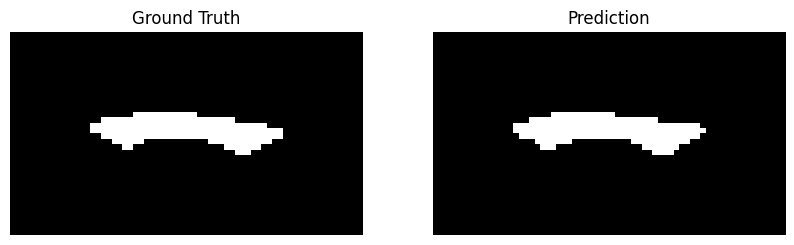

  1%|          | 59/6718 [00:26<36:22,  3.05it/s]

[0]
0.0
0.8571428571428571


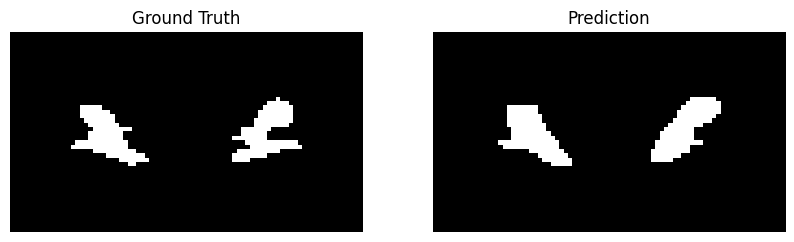

  1%|          | 60/6718 [00:26<39:09,  2.83it/s]

[13]
22.59765315055847
0.47876447876447875


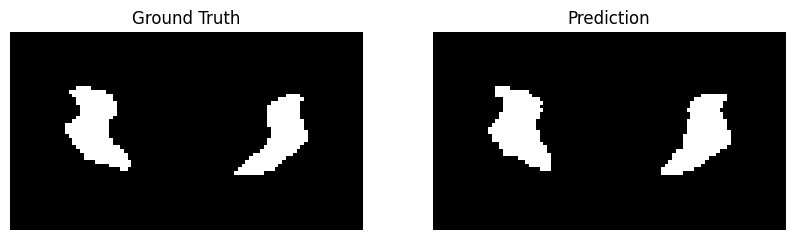

  1%|          | 61/6718 [00:26<40:30,  2.74it/s]

[6]
8.9296875
0.6547619047619048


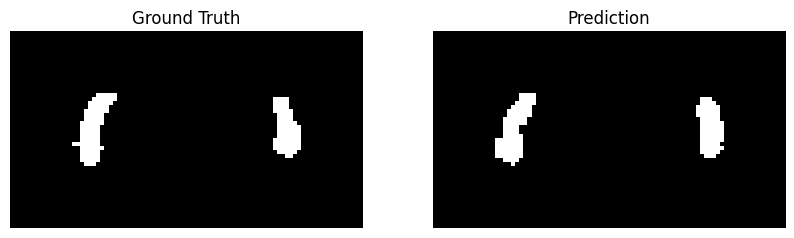

  1%|          | 62/6718 [00:27<41:09,  2.70it/s]

[1]
1.48828125
0.6772486772486772


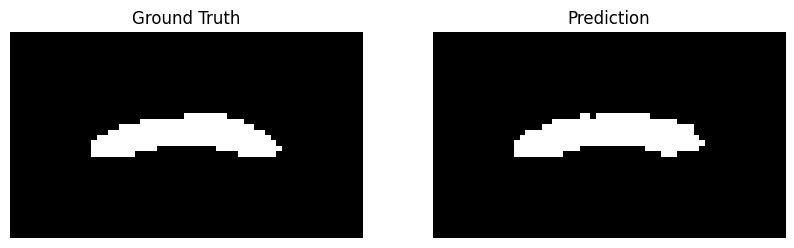

  1%|          | 63/6718 [00:27<37:46,  2.94it/s]

[0]
0.0
0.7674418604651163


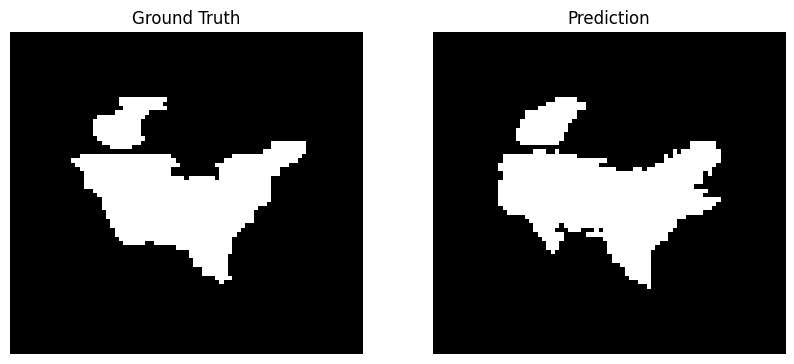

  1%|          | 64/6718 [00:28<39:41,  2.79it/s]

[30]
29.296875
0.390715667311412


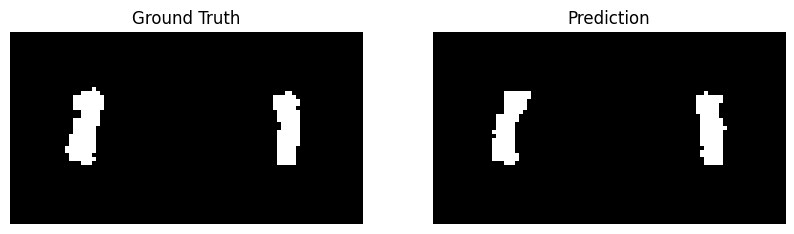

  1%|          | 65/6718 [00:28<40:32,  2.74it/s]

[4]
5.953125
0.6334841628959276


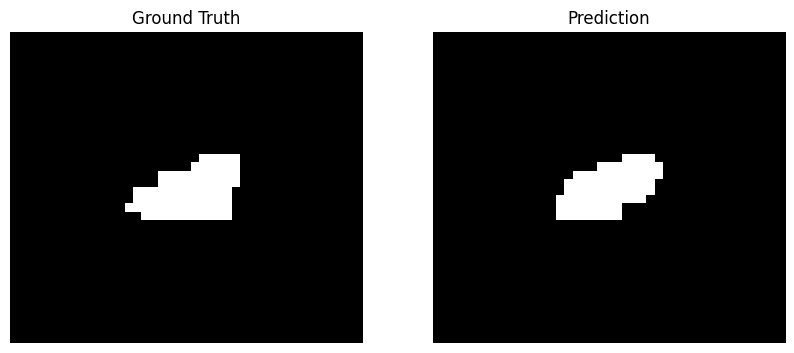

  1%|          | 66/6718 [00:28<37:59,  2.92it/s]

[3]
5.214843034744263
0.5974025974025974


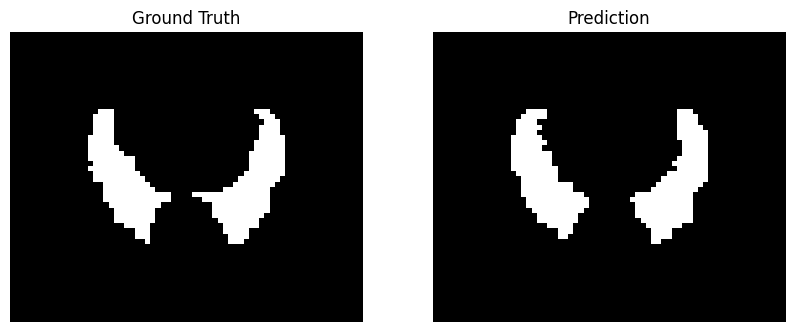

  1%|          | 67/6718 [00:28<36:26,  3.04it/s]

[2]
3.769531011581421
0.6871165644171779


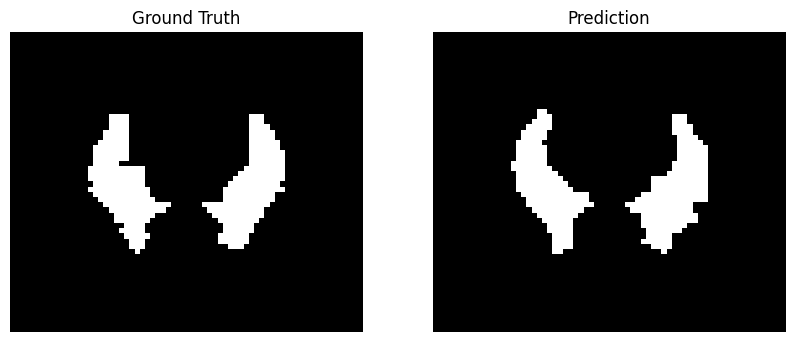

  1%|          | 68/6718 [00:29<35:09,  3.15it/s]

[1]
1.8847655057907104
0.6041055718475073


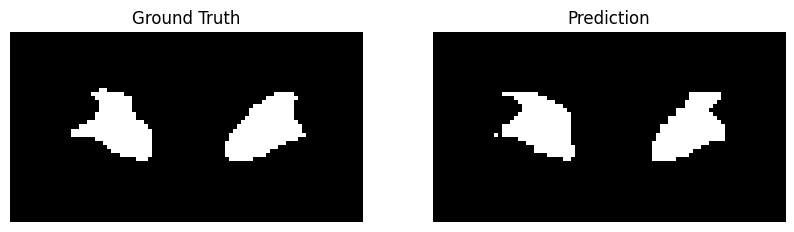

  1%|          | 69/6718 [00:29<38:03,  2.91it/s]

[3]
4.46484375
0.6872852233676976


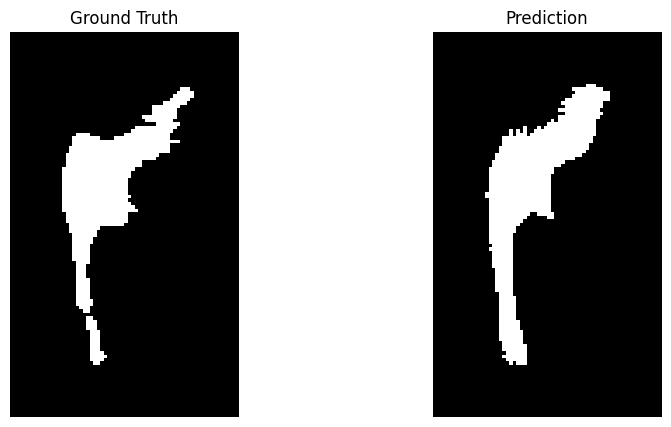

  1%|          | 70/6718 [00:30<49:07,  2.26it/s]

[55]
53.7109375
0.3511450381679389


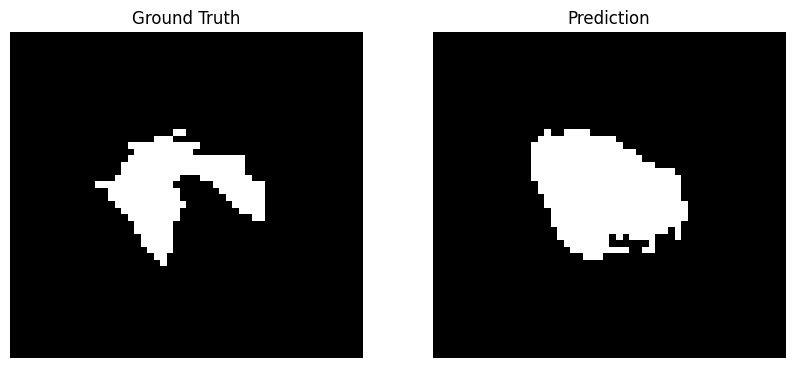

  1%|          | 71/6718 [00:30<44:23,  2.50it/s]

[29]
28.3203125
0.26732673267326734


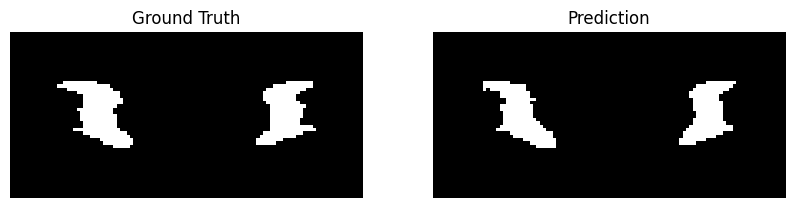

  1%|          | 72/6718 [00:31<43:40,  2.54it/s]

[11]
19.12109112739563
0.6685878962536023


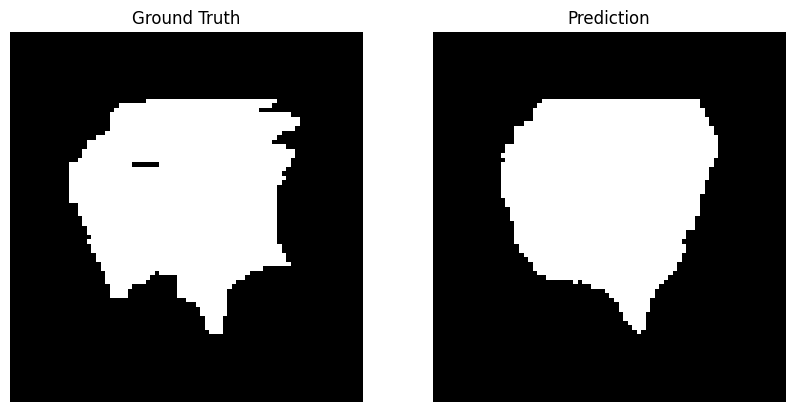

  1%|          | 73/6718 [00:31<41:09,  2.69it/s]

[68]
66.40625
0.4043956043956044


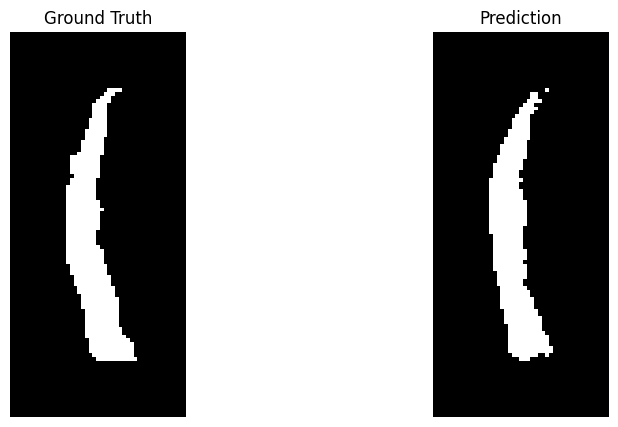

  1%|          | 74/6718 [00:31<38:40,  2.86it/s]

[9]
10.546875
0.5038560411311054


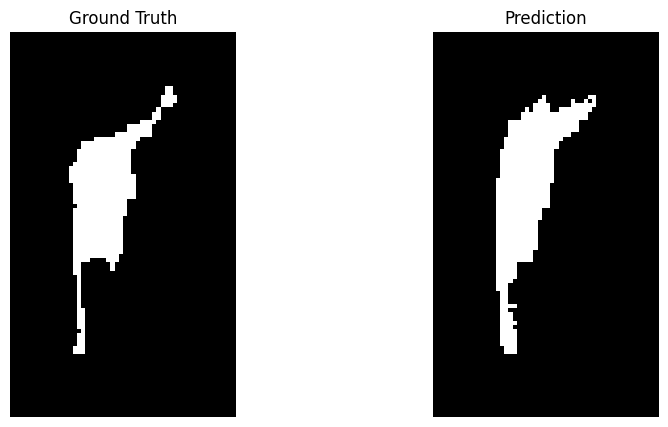

  1%|          | 75/6718 [00:31<36:59,  2.99it/s]

[35]
41.015625
0.4431818181818182


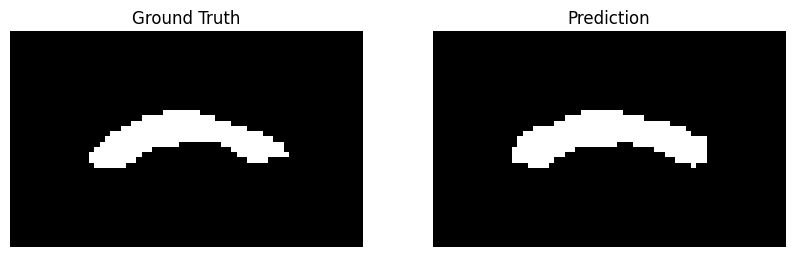

  1%|          | 76/6718 [00:32<35:14,  3.14it/s]

[0]
0.0
0.6732673267326733


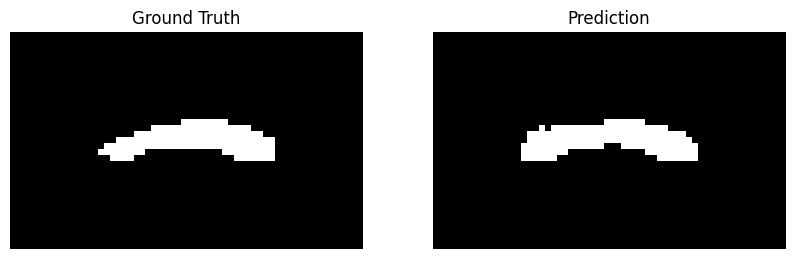

  1%|          | 77/6718 [00:32<33:41,  3.29it/s]

[0]
0.0
0.7333333333333333


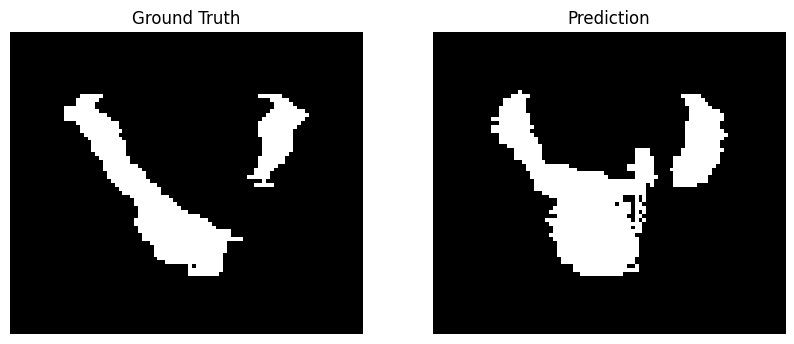

  1%|          | 78/6718 [00:32<36:49,  3.00it/s]

[78]
116.0859375
0.23920265780730898


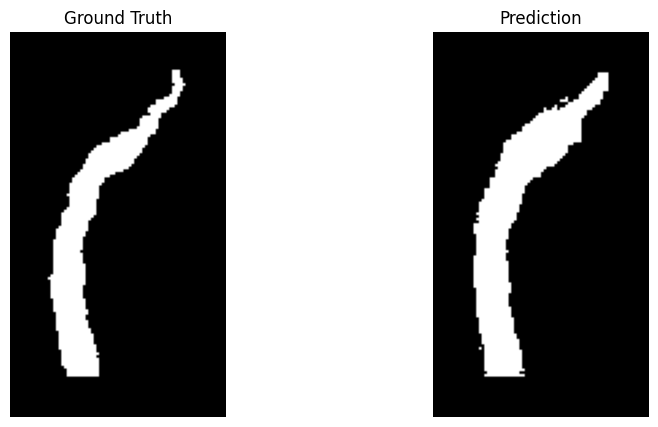

  1%|          | 79/6718 [00:33<36:55,  3.00it/s]

[65]
63.4765625
0.41251778093883357


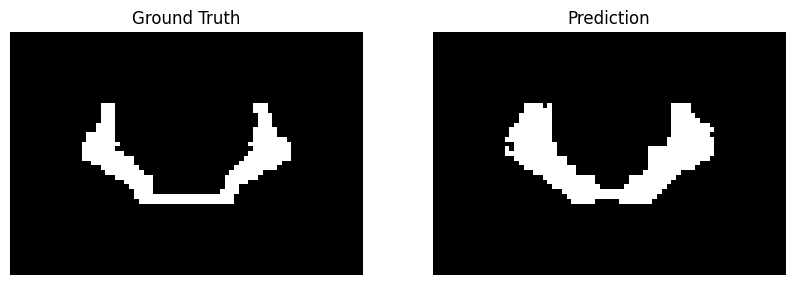

  1%|          | 80/6718 [00:33<35:40,  3.10it/s]

[22]
35.96484375
0.4226190476190476


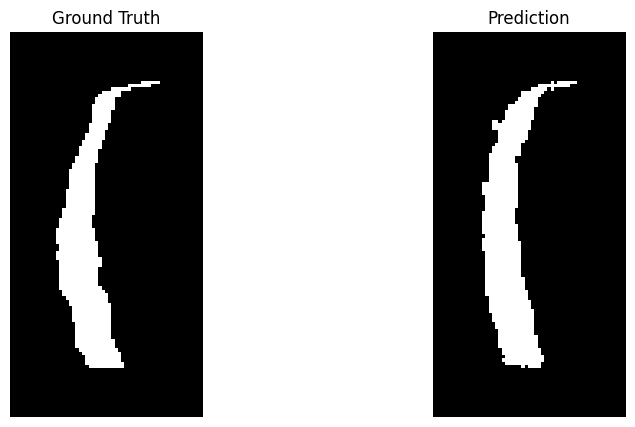

  1%|          | 81/6718 [00:33<34:38,  3.19it/s]

[25]
24.4140625
0.5346534653465347


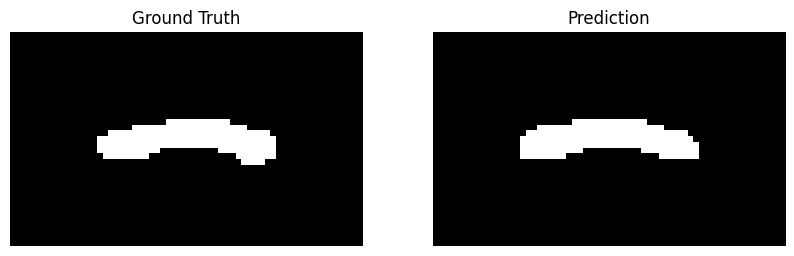

  1%|          | 82/6718 [00:34<33:51,  3.27it/s]

[0]
0.0
0.7922077922077922


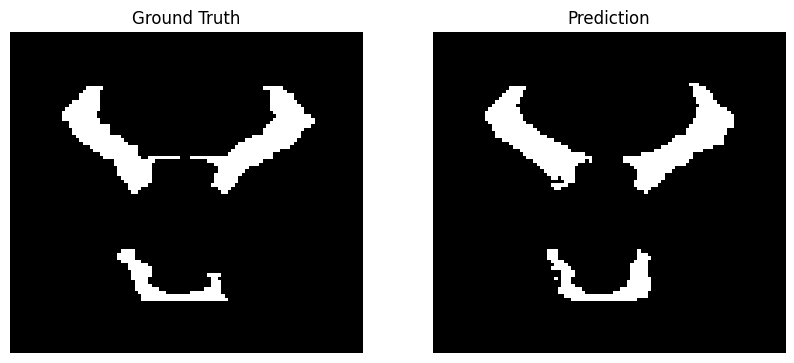

  1%|          | 83/6718 [00:34<36:37,  3.02it/s]

[15]
22.32421875
0.6195652173913043


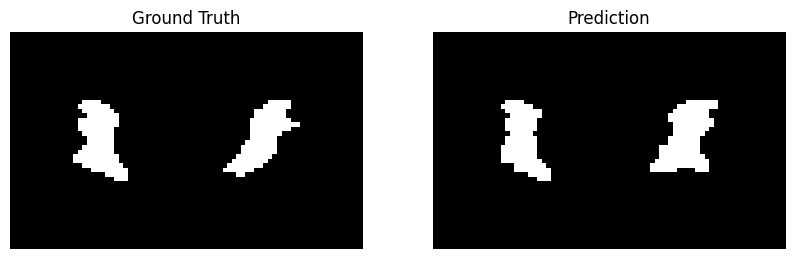

  1%|▏         | 84/6718 [00:34<38:31,  2.87it/s]

[1]
1.8359375
0.7258687258687259


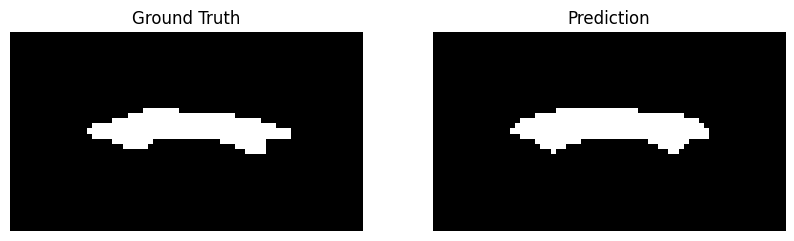

  1%|▏         | 85/6718 [00:35<37:09,  2.97it/s]

[0]
0.0
0.6528497409326425


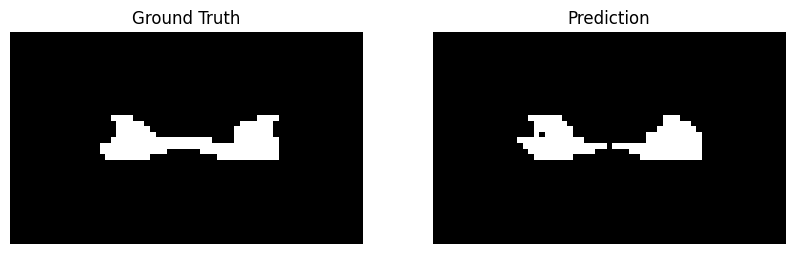

  1%|▏         | 86/6718 [00:35<35:33,  3.11it/s]

[1]
1.8847655057907104
0.7111111111111111


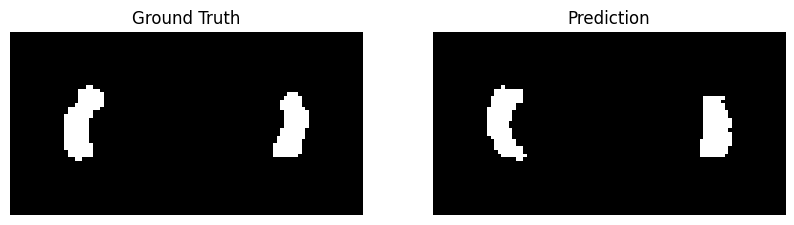

  1%|▏         | 87/6718 [00:35<38:32,  2.87it/s]

[8]
11.90625
0.4721030042918455


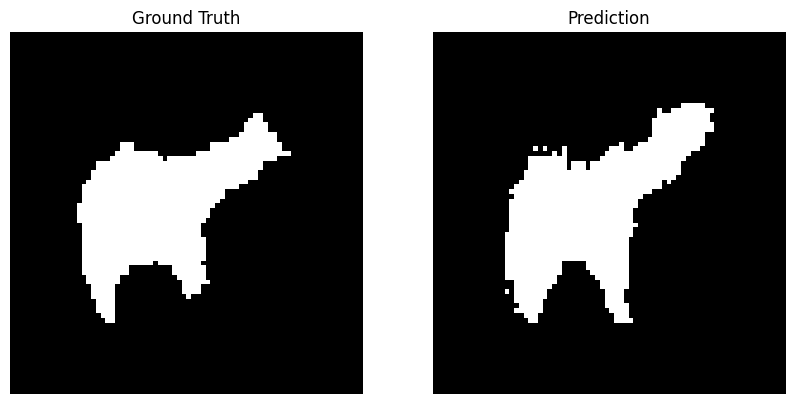

  1%|▏         | 89/6718 [00:36<29:19,  3.77it/s]

[28]
27.34375
0.3813953488372093


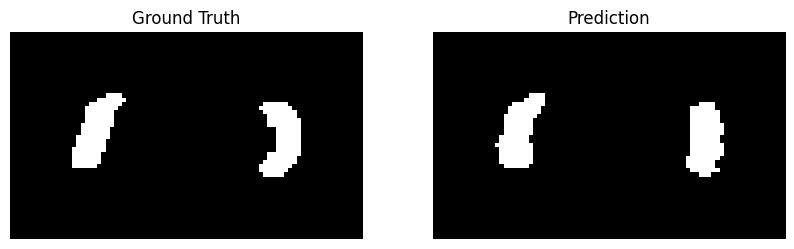

  1%|▏         | 90/6718 [00:36<32:36,  3.39it/s]

[9]
13.39453125
0.584070796460177


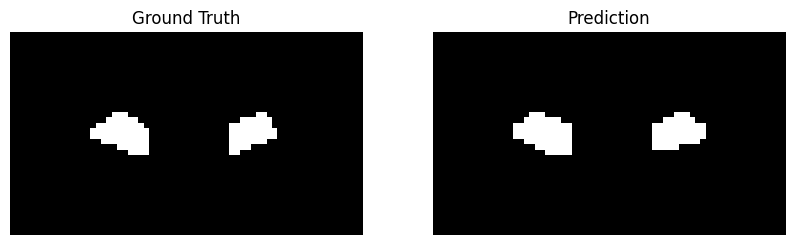

  1%|▏         | 91/6718 [00:37<35:59,  3.07it/s]

[0]
0.0
0.765625


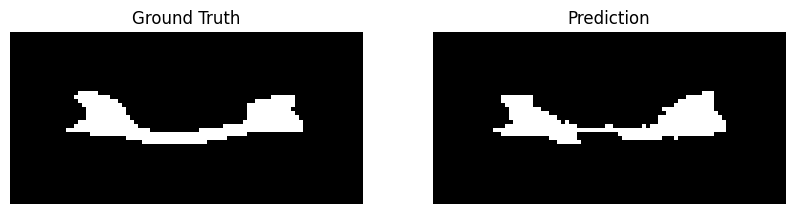

  1%|▏         | 92/6718 [00:37<35:39,  3.10it/s]

[9]
13.39453125
0.525


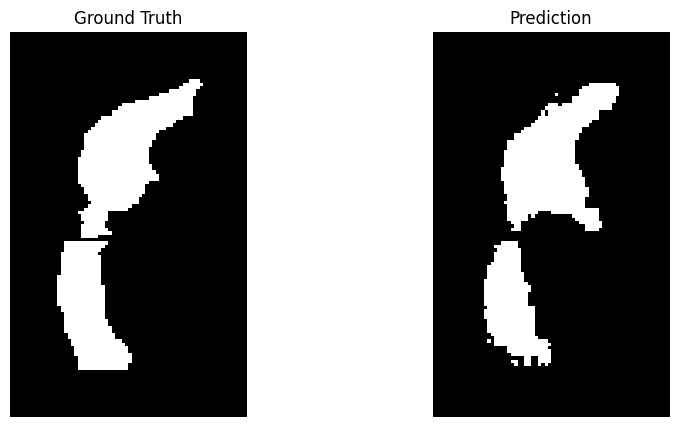

  1%|▏         | 93/6718 [00:37<37:53,  2.91it/s]

[62]
60.546875
0.3252818035426731


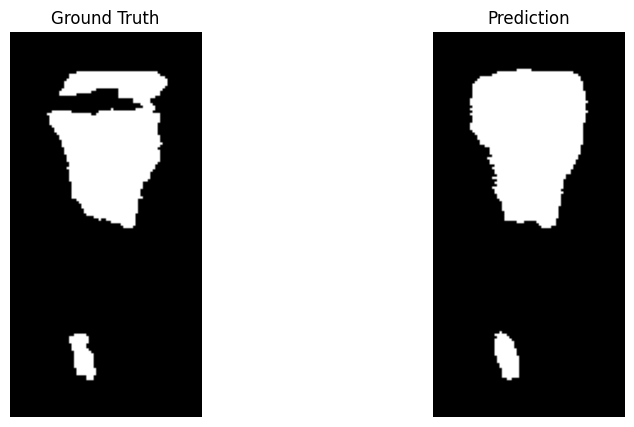

  1%|▏         | 94/6718 [00:38<41:10,  2.68it/s]

[113]
110.3515625
0.32190760059612517


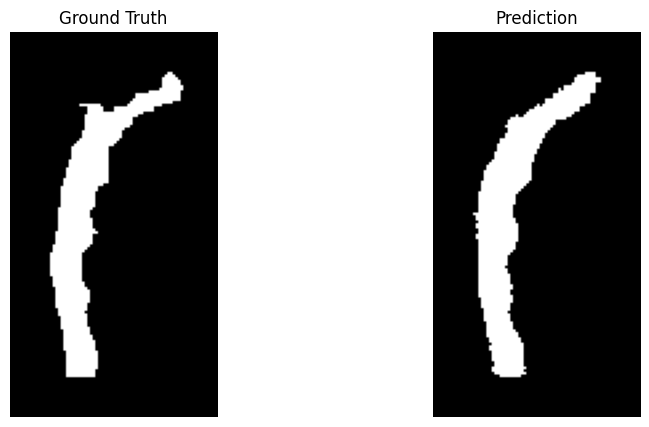

  1%|▏         | 95/6718 [00:38<41:13,  2.68it/s]

[62]
60.546875
0.35804195804195804


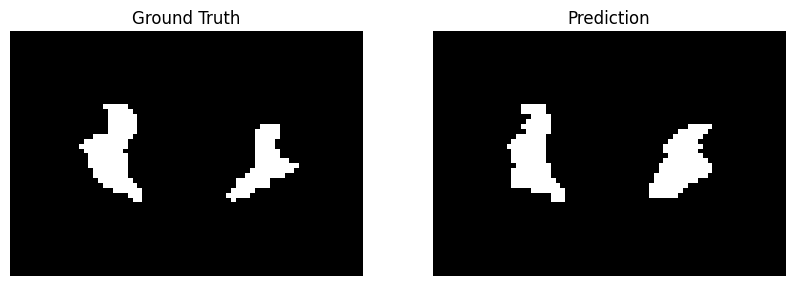

  1%|▏         | 96/6718 [00:38<41:19,  2.67it/s]

[13]
21.251953125
0.5533596837944664


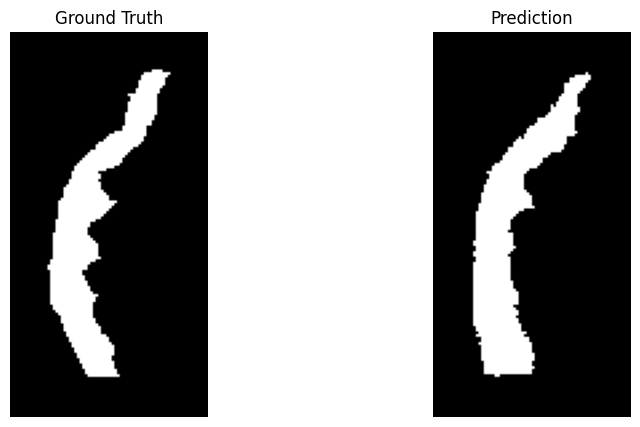

  1%|▏         | 97/6718 [00:39<39:15,  2.81it/s]

[82]
80.078125
0.3337856173677069


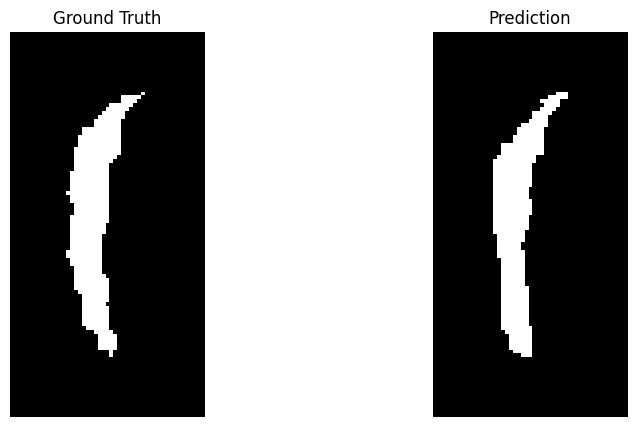

  1%|▏         | 98/6718 [00:39<37:01,  2.98it/s]

[20]
25.390620231628418
0.4192634560906516


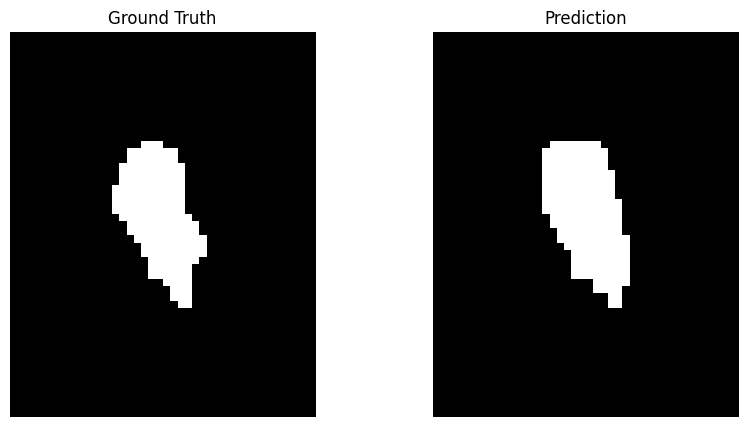

  1%|▏         | 99/6718 [00:39<38:09,  2.89it/s]

[3]
2.9296860694885254
0.5223880597014925


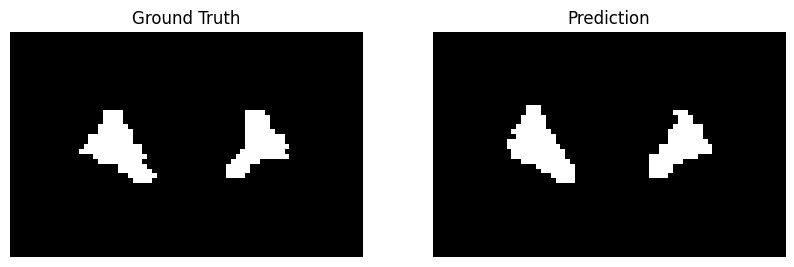

  1%|▏         | 100/6718 [00:40<39:05,  2.82it/s]

[0]
0.0
0.6697674418604651


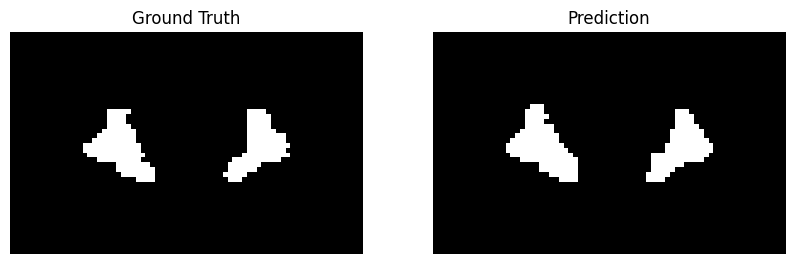

  2%|▏         | 101/6718 [00:40<39:37,  2.78it/s]

[2]
3.769531011581421
0.6875


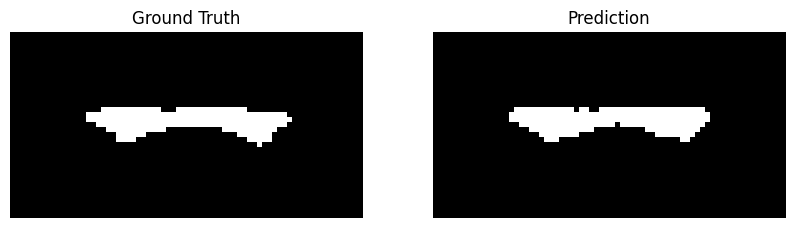

  2%|▏         | 102/6718 [00:40<36:59,  2.98it/s]

[0]
0.0
0.7722772277227723


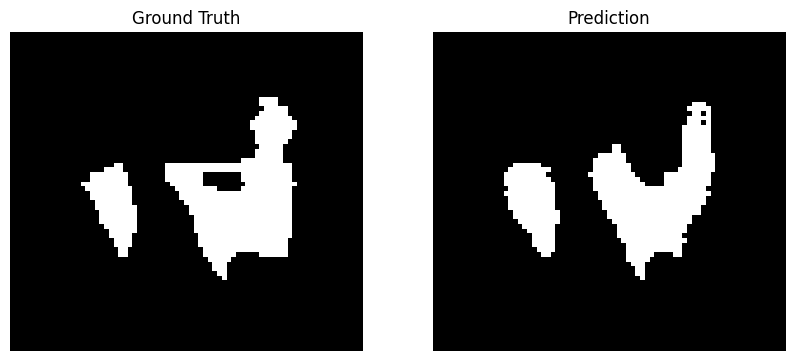

  2%|▏         | 103/6718 [00:41<40:32,  2.72it/s]

[49]
47.8515625
0.34451901565995524


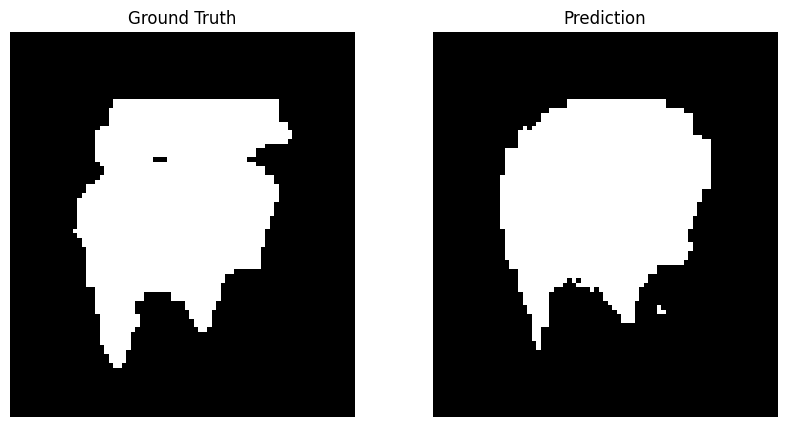

  2%|▏         | 104/6718 [00:41<38:39,  2.85it/s]

[92]
89.84375
0.34552845528455284


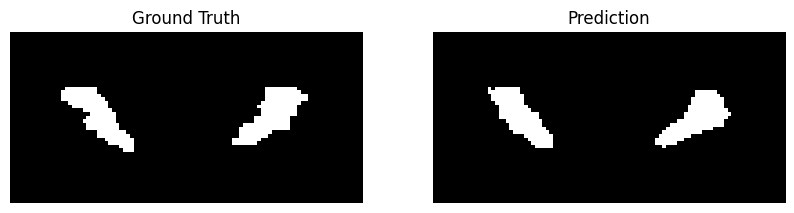

  2%|▏         | 105/6718 [00:42<51:50,  2.13it/s]

[12]
17.859375
0.5214285714285715


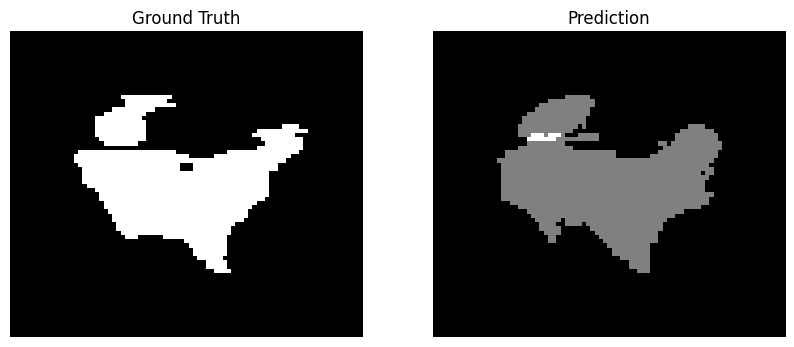

  2%|▏         | 106/6718 [00:42<50:05,  2.20it/s]

[48]
46.875
0.39823008849557523


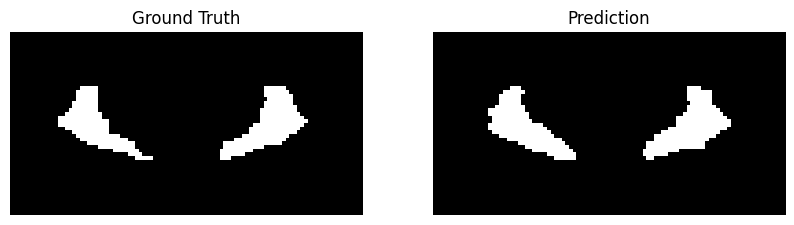

  2%|▏         | 107/6718 [00:43<47:25,  2.32it/s]

[10]
14.8828125
0.5964912280701754


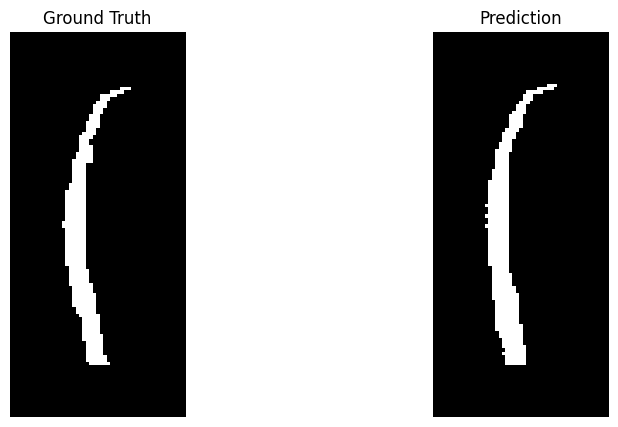

  2%|▏         | 108/6718 [00:43<42:48,  2.57it/s]

[10]
12.695310115814209
0.6747572815533981


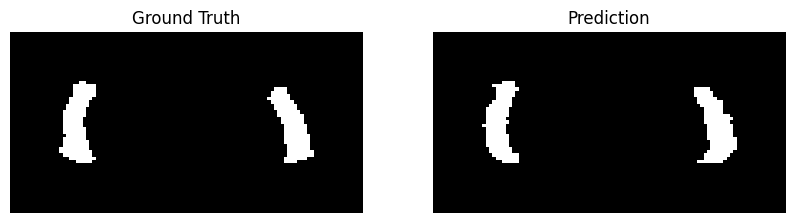

  2%|▏         | 109/6718 [00:43<43:28,  2.53it/s]

[1]
1.48828125
0.6086956521739131


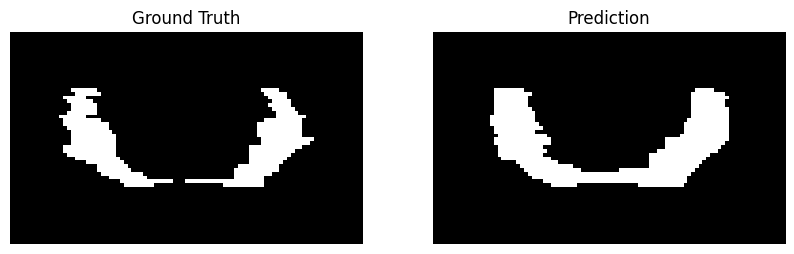

  2%|▏         | 110/6718 [00:44<40:58,  2.69it/s]

[47]
69.94921875
0.416135881104034


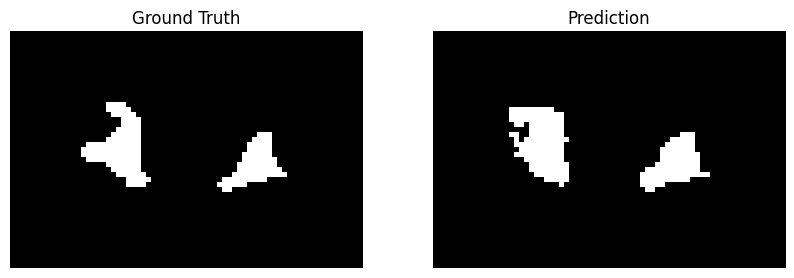

  2%|▏         | 111/6718 [00:44<41:20,  2.66it/s]

[5]
8.173828125
0.5596330275229358


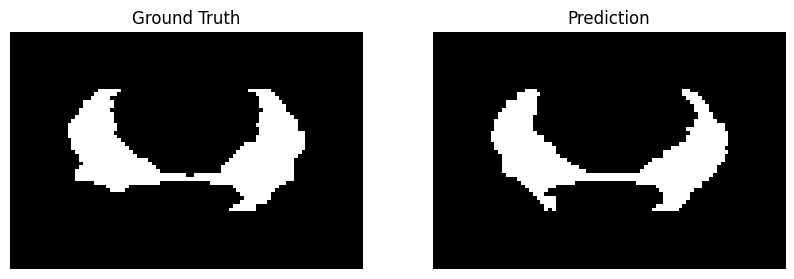

  2%|▏         | 112/6718 [00:44<38:16,  2.88it/s]

[11]
16.37109375
0.6247619047619047


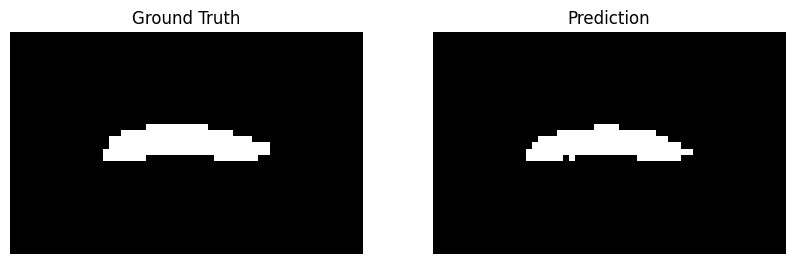

  2%|▏         | 113/6718 [00:45<36:08,  3.05it/s]

[0]
0.0
0.8031496062992126


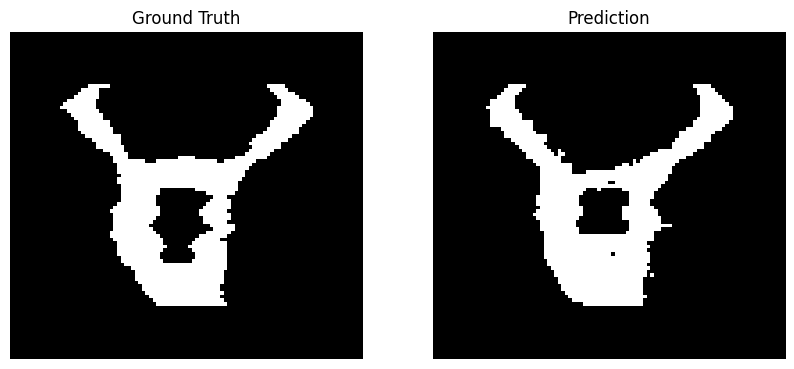

  2%|▏         | 114/6718 [00:45<35:38,  3.09it/s]

[40]
59.53125
0.5293440736478712


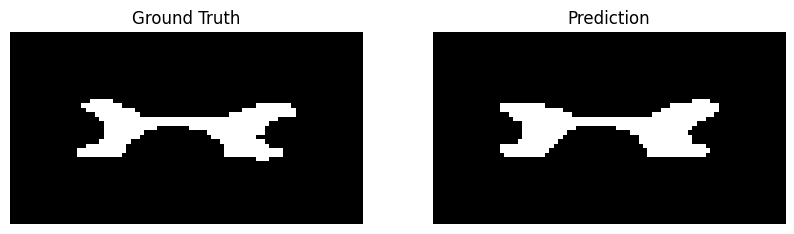

  2%|▏         | 115/6718 [00:45<35:25,  3.11it/s]

[2]
2.9765625
0.7018633540372671


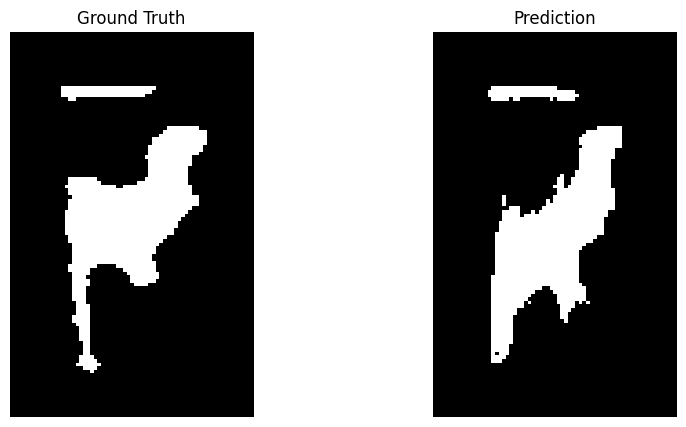

  2%|▏         | 116/6718 [00:46<37:32,  2.93it/s]

[88]
85.9375
0.3671497584541063


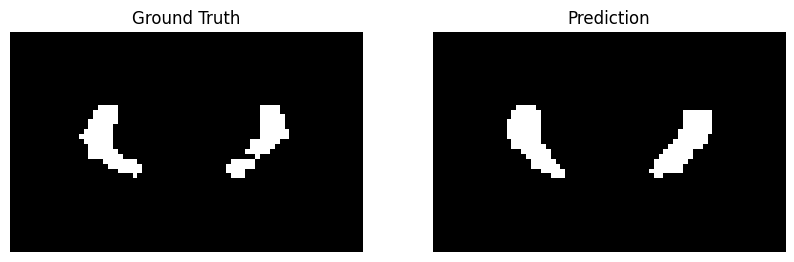

  2%|▏         | 117/6718 [00:46<38:31,  2.86it/s]

[2]
3.671875
0.5074626865671642


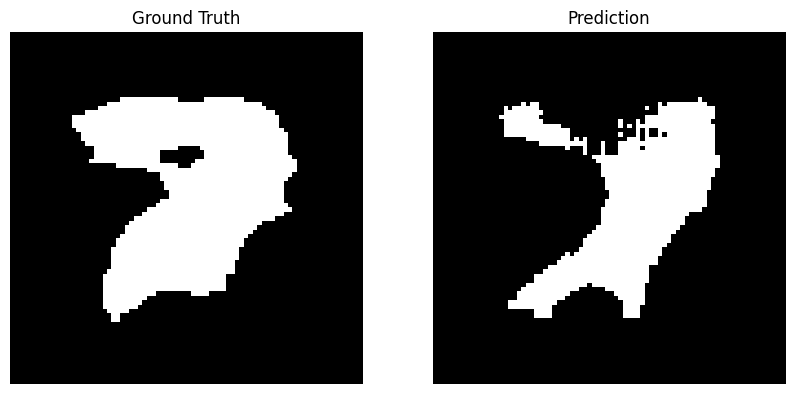

  2%|▏         | 118/6718 [00:46<38:14,  2.88it/s]

[95]
92.77339220046997
0.23367697594501718


  2%|▏         | 118/6718 [00:47<43:54,  2.50it/s]


KeyboardInterrupt: 

In [26]:
from platipy.imaging.label.comparison import compute_metric_total_apl, compute_surface_dsc, compute_metric_hd
import cv2
import numpy as np

overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

length_of_val_loader = len(dlh.val_loader)

# iterate through the validation loader
for i, batch in tqdm(enumerate(dlh.val_loader), total=length_of_val_loader):
    image_name = batch["image_name"][0]
    image_axis = batch["axis"].item()

    # check if we have already processed this name and axis
    if image_name in df.name.values and image_axis in df.axis.values:
        continue

    # Get data
    image = batch["image"].to(device)
    gt2D = batch["gt2D"].to(device)
    # coords_torch = batch["coords"].squeeze().to(device) # ([B, Ps, 2])
    boxes_torch = batch["boxes"].squeeze().reshape(batch_size, -1, 4).to(device) # ([B, Ps, 4])
    axis = batch["axis"].squeeze() # ([B])
    
    medsam_preds = []
    medsam_segs = []

    for b in torch.unique(boxes_torch.squeeze().reshape(-1, batch_size, 4), dim=0):
        b = b.reshape(batch_size, 1, 4)
        # print(b)
        medsam_lite_pred = model(image, None, b)
        medsam_seg_prob = torch.sigmoid(medsam_lite_pred)
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

        medsam_preds.append(medsam_lite_pred.detach().cpu())
        medsam_segs.append(medsam_seg)

    medsam_preds = torch.tensor(np.stack(medsam_preds))
    medsam_segs = torch.tensor(np.stack(medsam_segs))

    # do an OR operation on the medsam_segs
    medsam_seg = medsam_segs.sum(dim=0)

    # Get evaluation metrics
    y_gt_sitk = sitk.GetImageFromArray(gt2D[0].detach().cpu().numpy().astype(np.uint8))
    ypred_sitk = sitk.GetImageFromArray(medsam_seg[None, :, :].numpy().astype(np.uint8))

    # print(y_gt_sitk.GetSize(), ypred_sitk.GetSize())
    # print(y_gt_sitk.GetSpacing(), ypred_sitk.GetSpacing())

    y_gt_sitk, ypred_sitk = upsample_sitk_image_to_original(y_gt_sitk, ypred_sitk, image_name, image_axis)

    # print(y_gt_sitk.GetSize(), ypred_sitk.GetSize())
    # print(y_gt_sitk.GetSpacing(), ypred_sitk.GetSpacing())

    # ##############################################################

    # plot the the prediction vs the ground truth zoomed into the area of interest

    # Find contours in the segmentation map
    # contours, _ = cv2.findContours(np.uint8(sitk.GetArrayFromImage(ypred_sitk)[0]), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # # Initialize list to store bounding boxes
    # bounding_boxes = []

    # x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0

    # # Loop through contours to find bounding boxes
    # for contour in contours:
    #     # Get bounding box coordinates
    #     x, y, w, h = cv2.boundingRect(contour)
    #     x_min, y_min, x_max, y_max = min(x, x_min), min(y, y_min), max(x + w, x_max), max(y + h, y_max)
    #     # bounding_boxes.append([x - 20, y - 20, x + w + 20, y + h + 20])  # Format: (x_min, y_min, x_max, y_max)

    # # plot the ROI

    # fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # p = 15

    # ax[0].imshow(sitk.GetArrayFromImage(y_gt_sitk)[0][max(0, y_min - p):y_max + p, max(0, x_min - p):x_max + p], cmap='gray')
    # ax[0].set_title('Ground Truth')
    # ax[0].axis('off')

    # ax[1].imshow(sitk.GetArrayFromImage(ypred_sitk)[0][max(0, y_min - p):y_max + p, max(0, x_min - p):x_max + p], cmap='gray')
    # ax[1].set_title('Prediction')
    # ax[1].axis('off')

    # plt.show()

    # ##############################################################

    overlap_measures_filter.Execute(y_gt_sitk, ypred_sitk)
                
    dice = overlap_measures_filter.GetDiceCoefficient()
    jaccard = overlap_measures_filter.GetJaccardCoefficient()
    volume_similarity = overlap_measures_filter.GetVolumeSimilarity()

    apl = compute_metric_total_apl(y_gt_sitk, ypred_sitk, 0.5)
    surface_dsc = compute_surface_dsc(y_gt_sitk, ypred_sitk, 0.5)
    hd = compute_metric_hd(y_gt_sitk, ypred_sitk)

    print(apl)
    print(surface_dsc)

    # add metrics to dataframe

    new_record = pd.DataFrame([
        {'name': image_name, 'axis': image_axis, 'dice': dice, 'jaccard': jaccard, 'volume_similarity': volume_similarity, 'apl': apl, 'surface_distance': surface_dsc, 'hausdorff_distance': hd}
    ])

    df = pd.concat([df, new_record], ignore_index=True)

    if i % 10 == 0:
        # save the dataframe to a csv file
        df.to_csv(os.path.join(save_dir, 'validation.csv'), index=False)

df.to_csv(os.path.join(save_dir, 'validation.csv'), index=False)

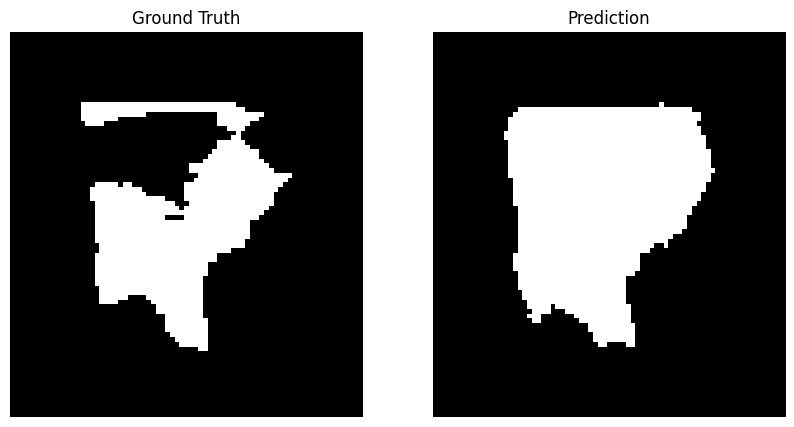

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

p = 15

ax[0].imshow(sitk.GetArrayFromImage(y_gt_sitk)[0][max(0, y_min - p):y_max + p, max(0, x_min - p):x_max + p], cmap='gray')
ax[0].set_title('Ground Truth')
ax[0].axis('off')

ax[1].imshow(sitk.GetArrayFromImage(ypred_sitk)[0][max(0, y_min - p):y_max + p, max(0, x_min - p):x_max + p], cmap='gray')
ax[1].set_title('Prediction')
ax[1].axis('off')

plt.show()

In [16]:
def compute_apl(label_ref, label_test, distance_threshold_mm=3):
    """
    helper function for computing the added path length

    Args:
        label_ref (sitk.Image): The reference (ground-truth) label
        label_test (sitk.Image): The test label
        distance_threshold_mm (float): Distances under this threshold will not contribute to the
            added path length

    Returns:
        float: The total (slice-wise) added path length in mm
    """
    added_path_length_list = []
    n_slices = label_ref.GetSize()[2]

    # convert the distance threshold to voxel units
    distance = int(np.ceil(distance_threshold_mm / np.mean(label_ref.GetSpacing()[:2])))

    # iterate over each slice
    for i in range(n_slices):

        if (
            sitk.GetArrayViewFromImage(label_ref)[i].sum()
            + sitk.GetArrayViewFromImage(label_test)[i].sum()
        ) == 0:
            continue

        label_ref_contour = sitk.LabelContour(label_ref[:, :, i])
        label_test_contour = sitk.LabelContour(label_test[:, :, i])

        if distance_threshold_mm > 0:
            kernel = [int(distance) for k in range(2)]
            label_test_contour = sitk.BinaryDilate(label_test_contour, kernel)

        # mask out the locations in agreement
        added_path = sitk.MaskNegated(label_ref_contour, label_test_contour)

        # add up the voxels on the added path
        added_path_length = sitk.GetArrayViewFromImage(added_path).sum()
        added_path_length_list.append(added_path_length)

    return added_path_length_list

compute_apl(y_gt_sitk, ypred_sitk, 1.0)

[69]

## plot the metrics per axis and total

In [54]:
df

,name,axis,dice,jaccard,volume_similarity,apl,surface_distance,hausdorff_distance
0,CT_zzAMLART_093-317.npy,2,0.884404,0.792763,-0.055046,0.000000,1.000000,2.762136
1,CT_zzAMLART_077-196.npy,1,0.880952,0.787234,-0.095238,0.000000,1.000000,2.683966
2,CT_zzAMLART_038-152.npy,0,0.719486,0.561873,-0.415418,6.539062,0.773438,9.108994
3,CT_zzAMLART_002-153.npy,0,0.955932,0.915584,0.020339,0.000000,1.000000,2.000000
4,CT_zzAMLART_077-077.npy,0,0.923963,0.858672,-0.013825,0.000000,1.000000,2.929686
...,...,...,...,...,...,...,...,...
4593,CT_zzAMLART_051-073.npy,0,0.906422,0.828859,0.011009,0.000000,1.000000,2.929686
4594,CT_zzAMLART_002-319.npy,2,0.893824,0.808030,-0.054129,0.000000,0.962733,4.367320
4595,CT_zzAMLART_071-190.npy,0,0.954436,0.912844,0.052758,0.000000,1.000000,2.000000
4596,CT_zzAMLART_073-105.npy,0,0.901961,0.821429,0.058824,0.000000,1.000000,2.539062


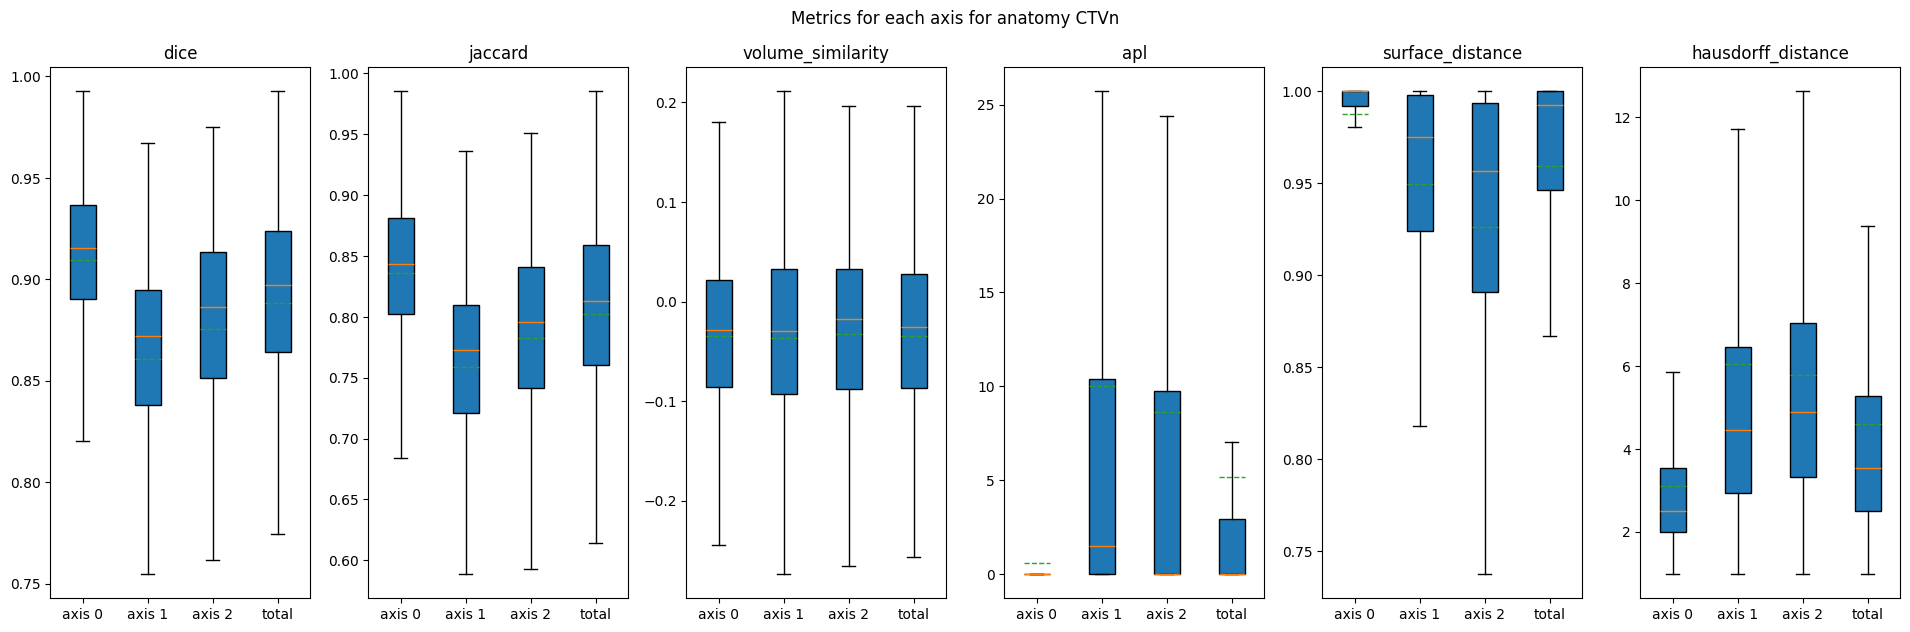

<Figure size 640x480 with 0 Axes>

In [55]:
# for each axis, plot the metrics

metrics = ['dice', 'jaccard', 'volume_similarity', 'apl', 'surface_distance', 'hausdorff_distance']

ncols = len(metrics)
nrows = 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2*1.6, nrows*4*1.6))
axs = axs.reshape(nrows, ncols)

for i in range(ncols):
    # get the column values
    column = metrics[i]

    # set the title of the cell to the metric type
    axs[0, i].set_title(column)

    # for each axis, plot the metric
    for axis in range(3):
        data = df[df.axis == axis]
        
        # for each axis, plot the boxplot with each axis being a different point on the x-axis labelled with axis-0, axis-1, axis-2.
        axs[0, i].boxplot(data[column], positions=[axis], showfliers=False, meanline=True, showmeans=True, patch_artist=True, widths=(.4))

    # now, we plot the total score across all axis

    axs[0, i].boxplot(df[column], positions=[3], showfliers=False, meanline=True, showmeans=True, patch_artist=True, widths=(.4))
    axs[0, i].set_xticklabels(['axis 0', 'axis 1', 'axis 2', 'total'])
        
    
plt.suptitle(f'Metrics for each axis for anatomy {anatomy}')
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(save_dir, 'validation_metrics.png'))